In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [1]:
import seaborn as sns
%matplotlib inline

In [3]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='10kbp_raw'

In [ ]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [346]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [347]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [1000]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.



In [421]:
cat_list_genes = marker_table.index.tolist()

In [349]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [350]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [2089]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())


In [3112]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.



marker_list.groupby(['group', 'cell_type'])['rank'].count().reset_index().sort_values(by=['rank']).tail(30)


marker_list.groupby(['group', 'cell_type'])['rank'].count().reset_index().groupby(['group'])['rank'].count().reset_index()

'Chandelier', 'Endo', 'L6 IT' 'Lamp5_Lhx6' 'OPC', 'Sst Chodl', 'VLMC'

In [3113]:
if marker_level == 'type':

    marker_list_t = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()
    

In [2522]:
#marker_list = marker_list.merge(pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker/marker_coexp.csv'))

#marker_list = marker_list[marker_list['AUC']>=0.2]

In [3114]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [3115]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

#df_gene_tp = df_gene_tp.fillna(0)

In [3116]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])




In [2416]:
list_nn =  df_gene_tp_all_info[df_gene_tp_all_info['classt'] == 'Non-neuronal'].drop_duplicates(subset=['cell_type'])['cell_type'].tolist()



In [2449]:
list_ga =  df_gene_tp_all_info[df_gene_tp_all_info['classt'] == 'GABAergic'].drop_duplicates(subset=['cell_type'])['cell_type'].tolist()


In [2397]:
df_gene_tp_all_info['group'] = [y if x=='Non-neuronal' else z for y,x,z in zip(df_gene_tp_all_info['cell_type'], df_gene_tp_all_info['classt'], df_gene_tp_all_info['group'])]



In [3130]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()



In [3141]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [3137]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

#df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
df_gene_tp_all_info_sub = df_gene_tp_all_info[df_gene_tp_all_info['classt']== 'GABAergic']
df_gene_tp_all_info_sub = df_gene_tp_all_info[df_gene_tp_all_info['group']== 'L4 IT']
df_gene_tp_all_info_mean = df_gene_tp_all_info_sub.groupby(['classt','group', 'cell_type']).mean()

In [2528]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [2215]:
import seaborn as sns
%matplotlib inline

In [3131]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

#lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('cell_type').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
#row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('cell_type').map(lut)

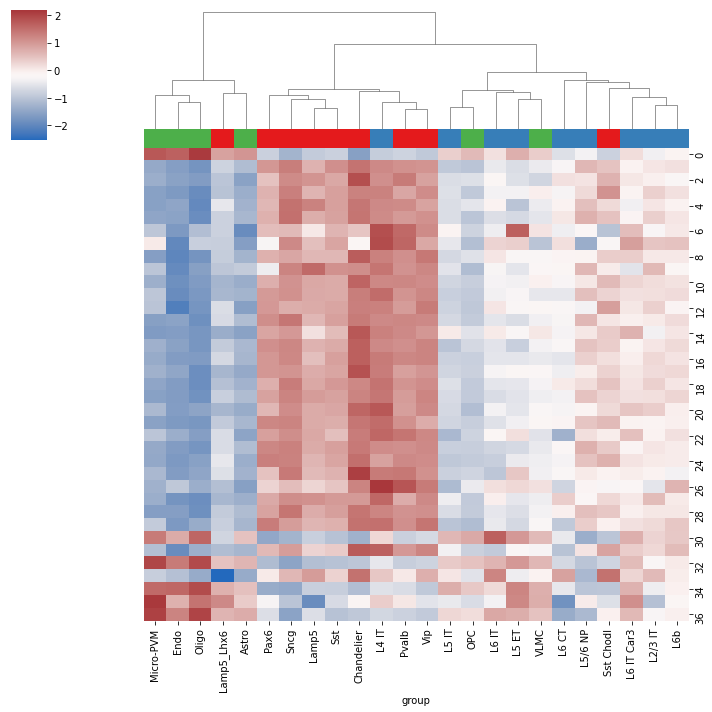

In [3158]:
#df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


<ipython-input-3163-0288997efaff>:20: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



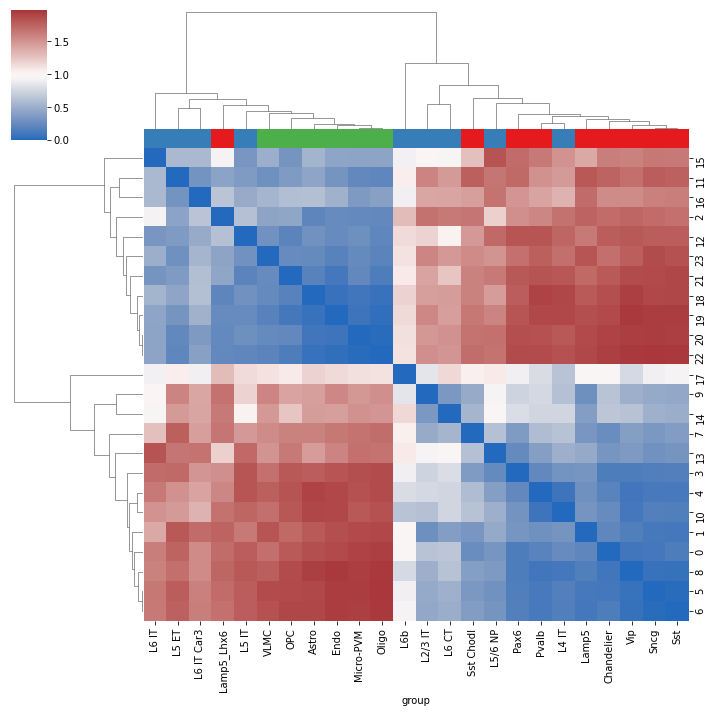

In [3163]:
#df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
#mean_list_df = pd.DataFrame(features_sc.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))


import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-np.round(np.corrcoef(features_sc) , 10)
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
mean_list_df = pd.DataFrame(df_dist.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))
sns.clustermap(mean_list_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", col_colors=row_colors)


<ipython-input-2717-9397deb5bdc8>:19: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



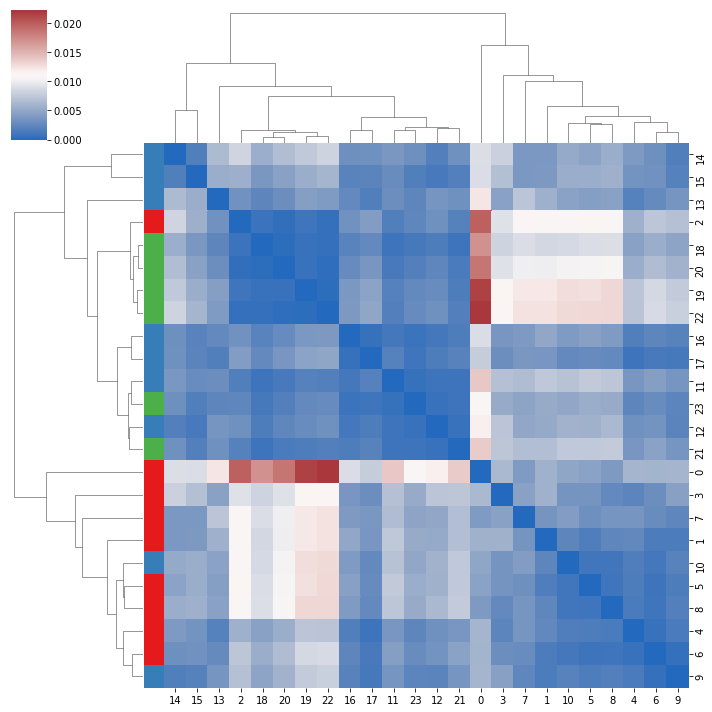

In [2717]:
#df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

#sns.clustermap(mean_list_df, col_cluster=True, row_cluster=True, robust=False, col_colors=[row_colors], cmap='vlag', metric="correlation", z_score=0)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-np.round(np.corrcoef((np.vstack(mean_list)).T), 10)
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [3119]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=100)


proj_2d = umap_2d.fit_transform(features_sc)

In [2723]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
proj_2d = tsne.fit_transform(features_sc)

In [2836]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features)

In [2835]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

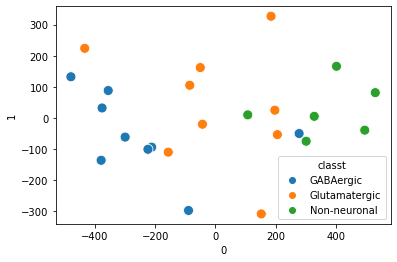

In [2834]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=100
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

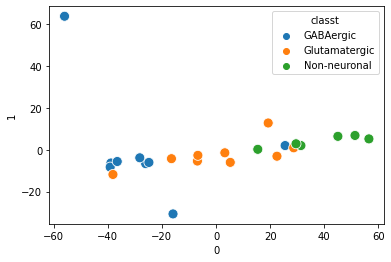

In [2837]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=100
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

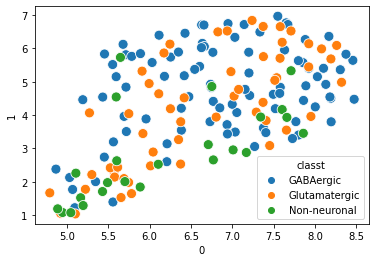

In [3120]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=100
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

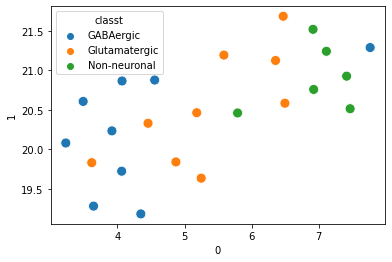

In [2728]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=100
)

<ipython-input-3156-7f992dcfb297>:9: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



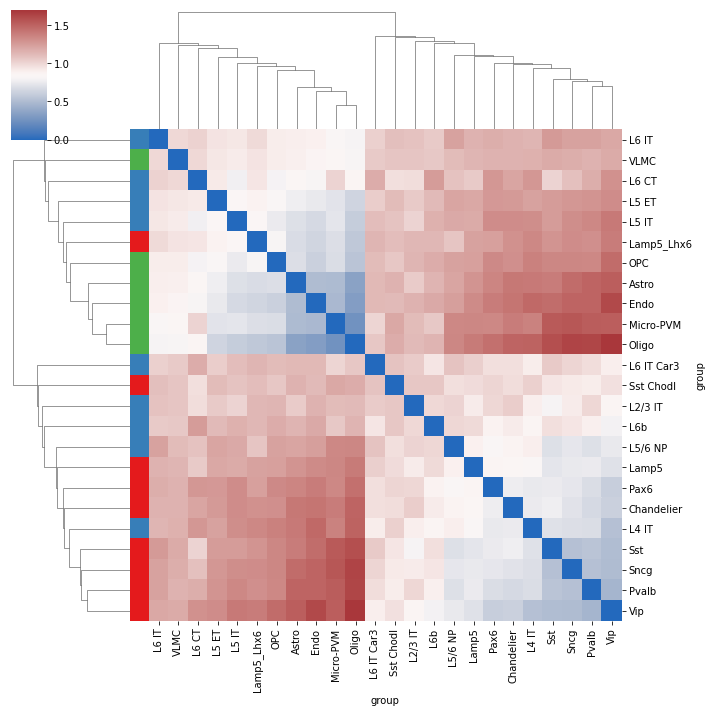

In [3156]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features  = features[0::]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
#R1 = np.round(scipy.stats.spearmanr(features).correlation, 10)

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [3153]:
features[0:19]

0         1         2         3         4       \
classt        group                                                          
GABAergic     Chandelier -1.485894 -0.776430 -1.312062 -0.973414 -1.078250   
              Lamp5      -1.404140 -0.816264 -1.215215 -1.126184 -1.061123   
              Lamp5_Lhx6 -1.292544 -0.599908 -1.068823 -1.016228 -0.925670   
              Pax6       -1.443221 -0.874539 -1.250825 -1.064590 -1.096928   
              Pvalb      -1.416918 -0.787600 -1.231134 -1.074568 -1.061396   
              Sncg       -1.431461 -0.879312 -1.282863 -1.115380 -1.080130   
              Sst        -1.392802 -0.762043 -1.203494 -0.988572 -0.947404   
              Sst Chodl  -1.373621 -0.917544 -1.163237 -1.034625 -1.034591   
              Vip        -1.448541 -0.880086 -1.297250 -1.125149 -1.088027   
Glutamatergic L2/3 IT    -1.372279 -0.787691 -1.227776 -1.067805 -1.042289   
              L4 IT      -1.476671 -1.010048 -1.390911 -1.105551 -1.144711   
              L5 ET      -1.367789 -0.707117 -1.222931 -1.041493 -0.917072   
              L5 IT      -1.326071 -0.665763 -1.161547 -0.984222 -0.918274   
              L5/6 NP    -1.368889 -0.788335 -1.218279 -1.078170 -1.008971   
              L6 CT      -1.306154 -0.434347 -1.115086 -0.871310 -0.950103   
              L6 IT      -1.385005 -0.854886 -1.237520 -1.063929 -1.041594   
              L6 IT Car3 -1.426864 -0.588805 -1.165579 -0.935507 -0.991532   
              L6b        -1.421057 -0.879263 -1.255415 -1.108598 -1.096531   
Non-neuronal  Astro      -1.307652 -0.759836 -1.183459 -1.003019 -1.005493   

                            5         6         7         8         9       \
classt        group                                                          
GABAergic     Chandelier -0.320466 -0.321429 -0.850198 -0.357350 -0.879858   
              Lamp5      -0.380274 -0.545636 -0.760965 -0.450108 -0.833237   
              Lamp5_Lhx6 -0.082121 -0.312024 -0.470009 -0.040812 -0.526896   
              Pax6       -0.355311 -0.522053 -0.728622 -0.397184 -0.848349   
              Pvalb      -0.374557 -0.448309 -0.632540 -0.296546 -0.747439   
              Sncg       -0.437740 -0.540416 -0.733819 -0.417285 -0.792845   
              Sst         0.030941 -0.181298 -0.577351 -0.102056 -0.690288   
              Sst Chodl  -0.523248 -0.542976 -0.660688 -0.357366 -0.721536   
              Vip        -0.326742 -0.509178 -0.722002 -0.435742 -0.829617   
Glutamatergic L2/3 IT    -0.396343 -0.472123 -0.696036 -0.361540 -0.758747   
              L4 IT      -0.413468 -0.485461 -0.726178 -0.323501 -0.757677   
              L5 ET      -0.021146 -0.157455 -0.520897  0.172766 -0.575743   
              L5 IT       0.004224 -0.003982 -0.445399  0.106402 -0.436349   
              L5/6 NP    -0.453358 -0.494643 -0.712346 -0.328401 -0.744140   
              L6 CT      -0.263550 -0.318470 -0.618928 -0.233452 -0.682393   
              L6 IT      -0.468971 -0.354747 -0.605972 -0.214641 -0.781887   
              L6 IT Car3  0.238946  0.042634 -0.528701  0.069221 -0.677650   
              L6b        -0.414958 -0.490790 -0.752653 -0.377155 -0.782726   
Non-neuronal  Astro      -0.343349 -0.331676 -0.577661 -0.165103 -0.620533   

                          ...    287499    287500    287501    287502  \
classt        group       ...                                           
GABAergic     Chandelier  ... -1.135260 -1.290352 -1.258105 -1.444296   
              Lamp5       ... -1.039948 -1.239624 -1.142467 -1.384705   
              Lamp5_Lhx6  ... -1.000363 -1.208638 -1.138910 -1.298306   
              Pax6        ... -1.056287 -1.280945 -1.191313 -1.428004   
              Pvalb       ... -1.059046 -1.258939 -1.140361 -1.410597   
              Sncg        ... -1.063959 -1.236382 -1.189840 -1.409498   
              Sst         ... -1.057510 -1.233015 -1.152656 -1.341246   
              Sst Chodl   ... -1.002404 -1.230699 -1.133778 -1.355371   
              Vip   

In [3150]:
df_gene_tp_all_info_mean

0         1         2         3         4       \
classt        group                                                          
GABAergic     Chandelier -1.485894 -0.776430 -1.312062 -0.973414 -1.078250   
              Lamp5      -1.404140 -0.816264 -1.215215 -1.126184 -1.061123   
              Lamp5_Lhx6 -1.292544 -0.599908 -1.068823 -1.016228 -0.925670   
              Pax6       -1.443221 -0.874539 -1.250825 -1.064590 -1.096928   
              Pvalb      -1.416918 -0.787600 -1.231134 -1.074568 -1.061396   
              Sncg       -1.431461 -0.879312 -1.282863 -1.115380 -1.080130   
              Sst        -1.392802 -0.762043 -1.203494 -0.988572 -0.947404   
              Sst Chodl  -1.373621 -0.917544 -1.163237 -1.034625 -1.034591   
              Vip        -1.448541 -0.880086 -1.297250 -1.125149 -1.088027   
Glutamatergic L2/3 IT    -1.372279 -0.787691 -1.227776 -1.067805 -1.042289   
              L4 IT      -1.476671 -1.010048 -1.390911 -1.105551 -1.144711   
              L5 ET      -1.367789 -0.707117 -1.222931 -1.041493 -0.917072   
              L5 IT      -1.326071 -0.665763 -1.161547 -0.984222 -0.918274   
              L5/6 NP    -1.368889 -0.788335 -1.218279 -1.078170 -1.008971   
              L6 CT      -1.306154 -0.434347 -1.115086 -0.871310 -0.950103   
              L6 IT      -1.385005 -0.854886 -1.237520 -1.063929 -1.041594   
              L6 IT Car3 -1.426864 -0.588805 -1.165579 -0.935507 -0.991532   
              L6b        -1.421057 -0.879263 -1.255415 -1.108598 -1.096531   
Non-neuronal  Astro      -1.307652 -0.759836 -1.183459 -1.003019 -1.005493   
              Endo       -1.283245 -0.147389 -1.102689 -0.725177 -0.902672   
              Micro-PVM  -1.346531 -0.513043 -1.058237 -0.823927 -0.965760   
              OPC        -1.304760 -0.658202 -1.117460 -0.985898 -0.982482   
              Oligo      -1.314089 -0.695944 -1.145389 -0.992939 -0.947581   
              VLMC       -1.362456 -0.820058 -1.228692 -1.045571 -1.024722   

                            5         6         7         8         9       \
classt        group                                                          
GABAergic     Chandelier -0.320466 -0.321429 -0.850198 -0.357350 -0.879858   
              Lamp5      -0.380274 -0.545636 -0.760965 -0.450108 -0.833237   
              Lamp5_Lhx6 -0.082121 -0.312024 -0.470009 -0.040812 -0.526896   
              Pax6       -0.355311 -0.522053 -0.728622 -0.397184 -0.848349   
              Pvalb      -0.374557 -0.448309 -0.632540 -0.296546 -0.747439   
              Sncg       -0.437740 -0.540416 -0.733819 -0.417285 -0.792845   
              Sst         0.030941 -0.181298 -0.577351 -0.102056 -0.690288   
              Sst Chodl  -0.523248 -0.542976 -0.660688 -0.357366 -0.721536   
              Vip        -0.326742 -0.509178 -0.722002 -0.435742 -0.829617   
Glutamatergic L2/3 IT    -0.396343 -0.472123 -0.696036 -0.361540 -0.758747   
              L4 IT      -0.413468 -0.485461 -0.726178 -0.323501 -0.757677   
              L5 ET      -0.021146 -0.157455 -0.520897  0.172766 -0.575743   
              L5 IT       0.004224 -0.003982 -0.445399  0.106402 -0.436349   
              L5/6 NP    -0.453358 -0.494643 -0.712346 -0.328401 -0.744140   
              L6 CT      -0.263550 -0.318470 -0.618928 -0.233452 -0.682393   
              L6 IT      -0.468971 -0.354747 -0.605972 -0.214641 -0.781887   
              L6 IT Car3  0.238946  0.042634 -0.528701  0.069221 -0.677650   
              L6b        -0.414958 -0.490790 -0.752653 -0.377155 -0.782726   
Non-neuronal  Astro      -0.343349 -0.331676 -0.577661 -0.165103 -0.620533   
              Endo        0.044826 -0.044237 -0.361571  0.300862 -0.323915   
              Micro-PVM  -0.239708 -0.260301 -0.509355 -0.122787 -0.680529   
              OPC        -0.284993 -0.390764 -0.587897 -0.361582 -0.651972   
              Oligo      -0.157177 -0.266070 -0.550611 -0.106934 -0.565009   
              VLMC       -0.445624 -0.463263 -0.7

In [3149]:
df_dist_df 

group       Chandelier     Lamp5  Lamp5_Lhx6      Pax6     Pvalb      Sncg  \
group                                                                        
Chandelier    0.000000  0.857567    1.301792  0.765584  0.664455  0.710941   
Lamp5         0.857567  0.000000    1.231307  0.863453  0.750662  0.744900   
Lamp5_Lhx6    1.301792  1.231307    0.000000  1.234137  1.308815  1.320946   
Pax6          0.765584  0.863453    1.234137  0.000000  0.685942  0.729586   
Pvalb         0.664455  0.750662    1.308815  0.685942  0.000000  0.531892   
Sncg          0.710941  0.744900    1.320946  0.729586  0.531892  0.000000   
Sst           0.769320  0.722700    1.285498  0.753969  0.554668  0.535537   
Sst Chodl     0.974098  0.982991    1.112397  1.008477  0.912605  0.925195   
Vip           0.619046  0.707373    1.394867  0.604478  0.465131  0.509248   
L2/3 IT       1.040397  0.915037    1.133279  1.004308  1.005031  0.919966   
L4 IT         0.751346  0.822907    1.343576  0.744534  0.687184  0.690909   
L5 ET         1.261346  1.203889    0.885188  1.267373  1.288721  1.276809   
L5 IT         1.320618  1.190260    0.840937  1.323903  1.340555  1.312203   
L5/6 NP       0.878230  0.893079    1.077718  0.828481  0.696633  0.729725   
L6 CT         1.216663  1.054134    0.943589  1.274690  1.177187  1.098417   
L6 IT         1.155140  1.157463    0.991650  1.175249  1.228670  1.226773   
L6 IT Car3    0.968373  1.035688    1.142679  0.969549  0.976080  1.012853   
L6b           0.920180  0.987858    1.138675  0.881103  0.898672  0.940799   
Astro         1.416666  1.289336    0.680102  1.357637  1.499505  1.465699   
Endo          1.426838  1.328377    0.647157  1.396806  1.502173  1.498613   
Micro-PVM     1.392363  1.349187    0.689722  1.343585  1.533147  1.562049   
OPC           1.305224  1.234904    0.812676  1.336176  1.342130  1.347321   
Oligo         1.499008  1.398185    0.573285  1.448130  1.633580  1.638672   
VLMC          1.157770  1.143313    0.950372  1.152695  1.159122  1.175171   

group            Sst  Sst Chodl       Vip   L2/3 IT  ...     L6 CT     L6 IT  \
group                                                ...                       
Chandelier  0.769320   0.974098  0.619046  1.040397  ...  1.216663  1.155140   
Lamp5       0.722700   0.982991  0.707373  0.915037  ...  1.054134  1.157463   
Lamp5_Lhx6  1.285498   1.112397  1.394867  1.133279  ...  0.943589  0.991650   
Pax6        0.753969   1.008477  0.604478  1.004308  ...  1.274690  1.175249   
Pvalb       0.554668   0.912605  0.465131  1.005031  ...  1.177187  1.228670   
Sncg        0.535537   0.925195  0.509248  0.919966  ...  1.098417  1.226773   
Sst         0.000000   0.942242  0.512619  0.806785  ...  1.014763  1.260695   
Sst Chodl   0.942242   0.000000  0.961648  1.070418  ...  0.972765  1.106031   
Vip         0.512619   0.961648  0.000000  0.863715  ...  1.304540  1.204133   
L2/3 IT     0.806785   1.070418  0.863715  0.000000  ...  0.977057  1.087948   
L4 IT       0.706652   1.027029  0.532906  0.902399  ...  1.273941  1.142700   
L5 ET       1.253999   1.117617  1.322335  1.058830  ...  0.924228  0.951711   
L5 IT       1.252094   1.084282  1.404787  1.014528  ...  0.780757  0.940331   
L5/6 NP     0.697800   0.972678  0.742477  1.016149  ...  1.090262  1.225797   
L6 CT       1.014763   0.972765  1.304540  0.977057  ...  0.000000  1.026293   
L6 IT       1.260695   1.106031  1.204133  1.087948  ...  1.026293  0.000000   
L6 IT Car3  1.053475   1.079898  0.901495  1.050056  ...  1.180498  1.027660   
L6b         0.972580   1.072093  0.794432  1.000180  ...  1.256072  1.054596   
Astro       1.393219   1.157089  1.528417  1.049204  ...  0.858513  0.905747   
Endo        1.461335   1.122187  1.617895  1.152920  ...  0.808439  0.893664   
Micro-PVM   1.543768   1.200428  1.526846  1.114611  ...  1.013545  0.822899   
OPC         1.347766   1.068599  1.465565  1.141637  ...  0.794901  0.913064   
Oligo       1.596224   1.184615  1.695763  1.124642

In [3142]:
df_go = df_gene_tp_all_info_mean[[0]].reset_index()

df_go['val'] = 1

df_go_table = df_go.pivot_table(index='group', columns='classt', values='val', aggfunc='sum')
df_go_table.fillna(0, inplace=True)

In [3077]:
df_gene_tp_all_info_mean.index.get_level_values('cell_type')

Index(['Chandelier_1', 'Chandelier_2', 'Lamp5_1', 'Lamp5_2', 'Lamp5_3',
       'Lamp5_4', 'Lamp5_5', 'Lamp5_6', 'Lamp5_Lhx6_1', 'Lamp5_Lhx6_2',
       ...
       'Oligo_2', 'Oligo_3', 'Oligo_4', 'Oligo_5', 'Oligo_6', 'Oligo_7',
       'Oligo_8', 'Oligo_9', 'VLMC_1', 'VLMC_2'],
      dtype='object', name='cell_type', length=170)

In [3143]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
R1 = R1 + abs(R1.min())
df_dist_df = pd.DataFrame(R1 ,  index=df_gene_tp_all_info_mean.index.get_level_values('group'), columns = df_gene_tp_all_info_mean.index.get_level_values('group'))


In [ ]:
features = df_gene_tp_all_info_mean.loc[df_gene_tp_all_info_mean.index[0:100], all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
R1 = R1 + abs(R1.min())
df_dist_df = pd.DataFrame(R1 ,  index=df_gene_tp_all_info_mean[0:100].index.get_level_values('cell_type'), columns = df_gene_tp_all_info_mean[0:100].index.get_level_values('cell_type'))


In [3032]:
df_tmp = df_go_table.sample(frac=1).reset_index(drop=True)
df_tmp = df_tmp.set_index(df_go_table.index)

In [3033]:
df_tmp = df_go_table.sample(frac=1).reset_index()
df_tmp = df_tmp.set_index(df_go_table.index)

(18, 18)
(18, 3)
0.6666666666666667
0.0


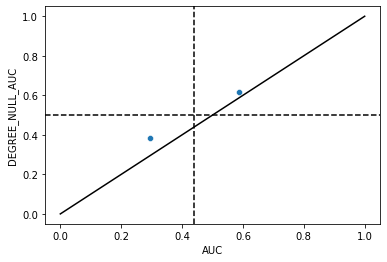

In [3034]:

        df_2d_jac, go_chrom  = run_egad(df_tmp[df_tmp['group'].isin(df_go_table[df_go_table['Non-neuronal']==0].index)].drop(['group'], axis=1), df_dist_df )
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        plt.plot([0, 1], [0, 1], c='black')
        plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')
        

In [3031]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.475309        17.427036         0.432099  0.424867
Glutamatergic  0.564815        17.495045         0.567901  0.286557

(24, 24)
(24, 3)
0.6666666666666667
0.00347222222222221


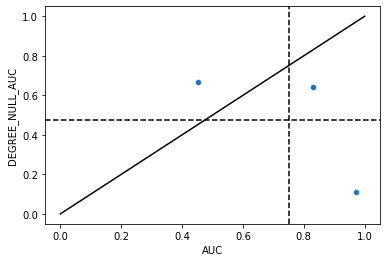

In [3135]:

        df_2d_jac, go_chrom  = run_egad(df_go_table, df_dist_df )
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        plt.plot([0, 1], [0, 1], c='black')
        plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')
        

(24, 24)
(24, 3)
0.6666666666666667
0.00347222222222221


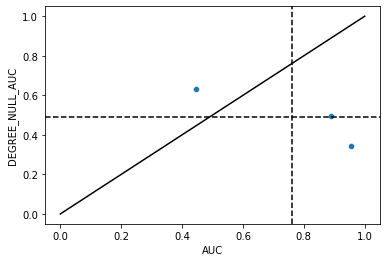

In [3144]:

        df_2d_jac, go_chrom  = run_egad(df_go_table, df_dist_df )
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        plt.plot([0, 1], [0, 1], c='black')
        plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')
        

In [3145]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.888889        16.025033         0.496296  0.000165
Glutamatergic  0.444444        16.095257         0.629630  0.303979
Non-neuronal   0.953704        15.975251         0.342593  0.000182

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



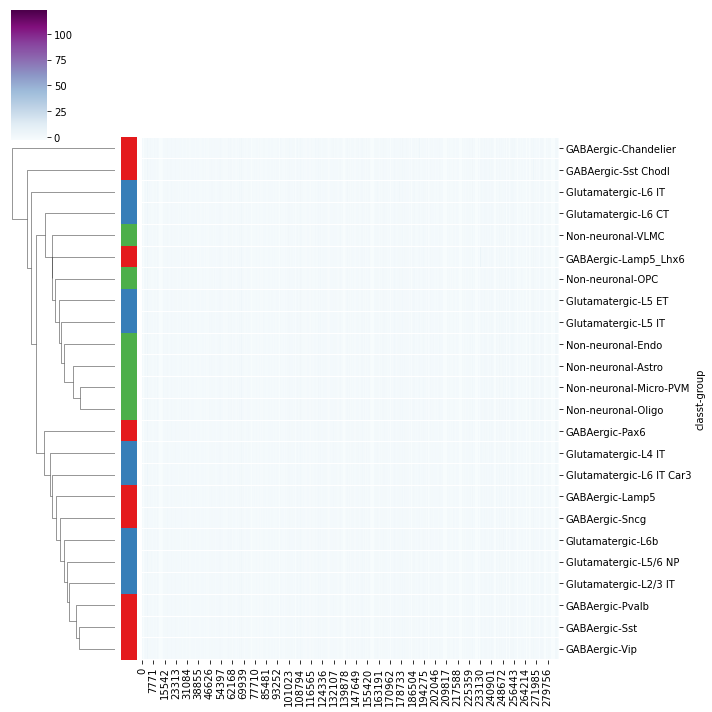

In [3003]:
sns.clustermap(features, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors, z_score=0)


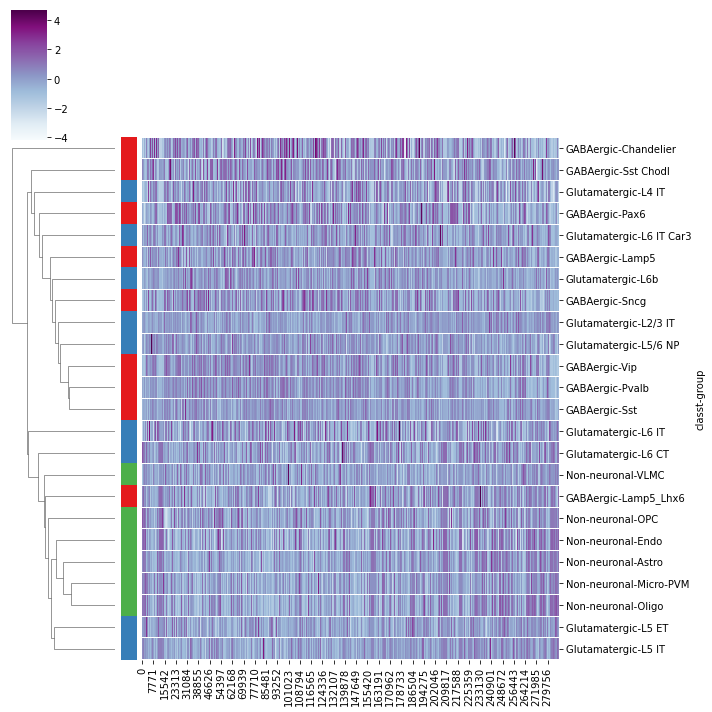

In [3004]:
sns.clustermap(features, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors, z_score=1)

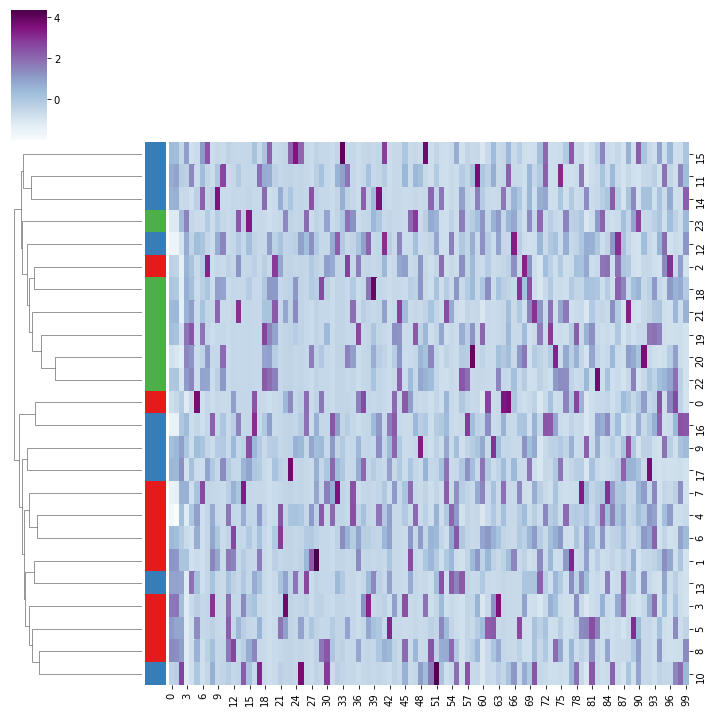

In [2893]:

from sklearn.decomposition import NMF



features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
features_sc = abs(features_sc.min()) + features_sc

model = NMF(n_components=100, init='random', random_state=2)
W = model.fit_transform(features_sc)
H = model.components_

sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors,  z_score=1, metric="correlation")


In [2894]:
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False,row_colors=row_colors, metric="correlation")



In [2918]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [2856]:
abs(features_sc.min())

4.2432675

In [2852]:
features_sc.min()

-4.2432675

In [ ]:
R1 = np.round(np.corrcoef(features_sc), 10)
#R1 = np.round(scipy.stats.spearmanr(features).correlation, 10)

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)
#sns.clustermap(features_sc, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors,  z_score=1, metric="correlation")



In [ ]:
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=1, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

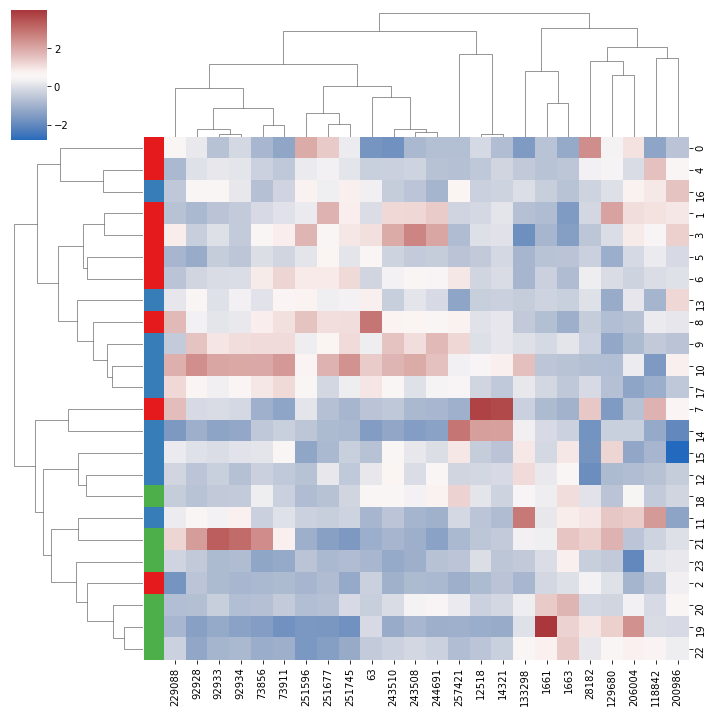

In [2809]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std <=1) & (all_bins_mean >=3)].index.tolist()].reset_index(drop=True), cmap="vlag", col_cluster=True, robust=False, row_colors=row_colors,  z_score=1, metric="correlation")


In [2740]:
all_bins_std[all_bins_std <=0.1]

0         0.059041
2         0.079125
3         0.098036
4         0.068178
11        0.082959
            ...   
287501    0.054030
287502    0.056124
287503    0.090835
287507    0.069821
287508    0.056909
Length: 216775, dtype: float32

In [2839]:

X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=1, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [2840]:
X

array([[1. , 1. ],
       [2. , 1. ],
       [3. , 1.2],
       [4. , 1. ],
       [5. , 0.8],
       [6. , 1. ]])

In [2841]:
W

array([[0.44172606],
       [0.80091914],
       [1.17661881],
       [1.51930528],
       [1.86199176],
       [2.23769143]])

In [2842]:
H

array([[2.6444043 , 0.60761512]])

In [2711]:
np.percentile(all_bins_mean, 5)

-1.374691081047058

In [ ]:
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag")

In [2287]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.05].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

In [2288]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

In [2323]:
df_gene_tp_all_info_mean

0         1         2         3       \
classt    group      cell_type                                              
GABAergic Chandelier Chandelier_1 -1.544762 -0.723126 -1.339276 -1.051737   
                     Chandelier_2 -1.403479 -0.851057 -1.273962 -0.863761   
          Lamp5      Lamp5_1      -1.347335 -0.817658 -1.180565 -0.998445   
                     Lamp5_2      -1.548197 -0.953553 -1.251968 -1.334702   
                     Lamp5_3      -1.350589 -0.714691 -1.156570 -1.046213   
...                                     ...       ...       ...       ...   
          Vip        Vip_5        -1.448329 -0.846759 -1.215434 -1.155947   
                     Vip_6        -1.438850 -1.105990 -1.279114 -1.072877   
                     Vip_7        -1.555596 -1.030086 -1.438290 -1.318392   
                     Vip_8        -1.438915 -1.013106 -1.381016 -1.234665   
                     Vip_9        -1.479722 -0.926834 -1.214514 -1.202742   

                                     4         5         6         7       \
classt    group      cell_type                                              
GABAergic Chandelier Chandelier_1 -1.136459 -0.429970 -0.340489 -0.847482   
                     Chandelier_2 -0.996757 -0.167161 -0.294745 -0.854001   
          Lamp5      Lamp5_1      -1.135304 -0.417958 -0.697517 -0.847716   
                     Lamp5_2      -1.149554 -0.412806 -0.503761 -0.663200   
                     Lamp5_3      -1.017681 -0.242910 -0.641123 -0.891271   
...                                     ...       ...       ...       ...   
          Vip        Vip_5        -1.207952 -0.610666 -0.671788 -0.966184   
                     Vip_6        -1.054945 -0.053599 -0.772355 -0.613128   
                     Vip_7        -1.250475 -0.628208 -0.659495 -0.840366   
                     Vip_8        -1.094014 -0.576522 -0.639601 -0.749468   
                     Vip_9        -1.056969  0.370327 -0.170171 -0.606501   

                                     8         9       ...    287499  \
classt    group      cell_type                         ...             
GABAergic Chandelier Chandelier_1 -0.246247 -0.817476  ... -1.139388   
                     Chandelier_2 -0.512895 -0.967193  ... -1.128723   
          Lamp5      Lamp5_1      -0.410566 -0.877858  ... -1.011343   
                     Lamp5_2      -0.350236 -0.934274  ... -1.120987   
                     Lamp5_3      -0.645210 -0.819677  ... -1.099699   
...                                     ...       ...  ...       ...   
          Vip        Vip_5        -0.792528 -0.852745  ... -1.261818   
                     Vip_6        -0.275215 -0.848708  ... -0.975108   
                     Vip_7        -0.522349 -1.004984  ... -1.169448   
                     Vip_8        -0.542208 -0.833576  ... -1.065335   
                     Vip_9        -0.394487 -1.025432  ... -1.134248   

                                     287500    287501    287502    287503  \
classt    group      cell_type                                              
GABAergic Chandelier Chandelier_1 -1.303991 -1.271872 -1.485523 -0.872973   
                     Chandelier_2 -1.268757 -1.236306 -1.379020 -0.808877   
          Lamp5      Lamp5_1      -1.168828 -1.070763 -1.325840 -0.591003   
                     Lamp5_2      -1.376095 -1.252741 -1.541306 -0.927628   
                     Lamp5_3      -1.226191 -1.074942 -1.283617 -0.716138   
...                                     ...       ...       ...       ...   
          Vip        Vip_5        -1.299396 -1.287168 -1.428611 -0.680329   
                     Vip_6        -1.346429 -1.171425 -1.358656 -0.626579   
                     Vip_7        -1.291564 -1.240835 -1.523108 -0.677820   
                     Vip_8        -1.386133 -1.127341 -1.425976 -0.674585   
                     Vip_9        -1.341962 -1.245221 -1.479722 -0.773824   

                                     287504    287505    287506    287507  \
classt    group  

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



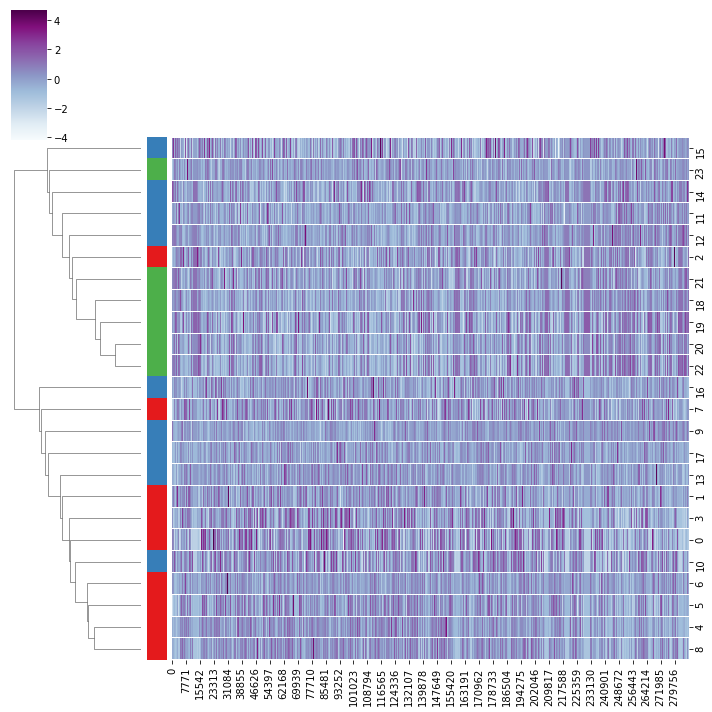

In [2721]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors,  z_score=1, metric="correlation")


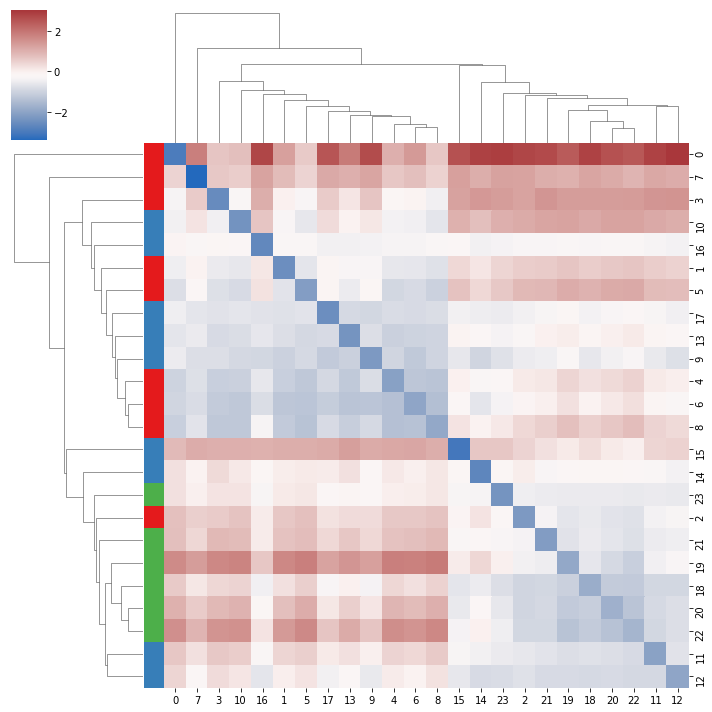

In [2622]:
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [2315]:
df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates()

Index(['Chandelier', 'Lamp5', 'Lamp5_Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst',
       'Sst Chodl', 'Vip'],
      dtype='object', name='group')

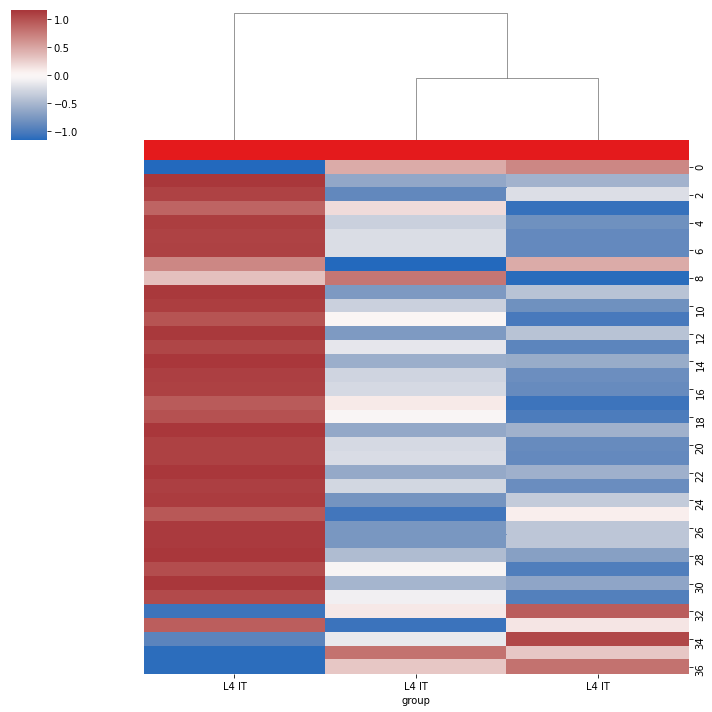

In [2327]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


In [2259]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

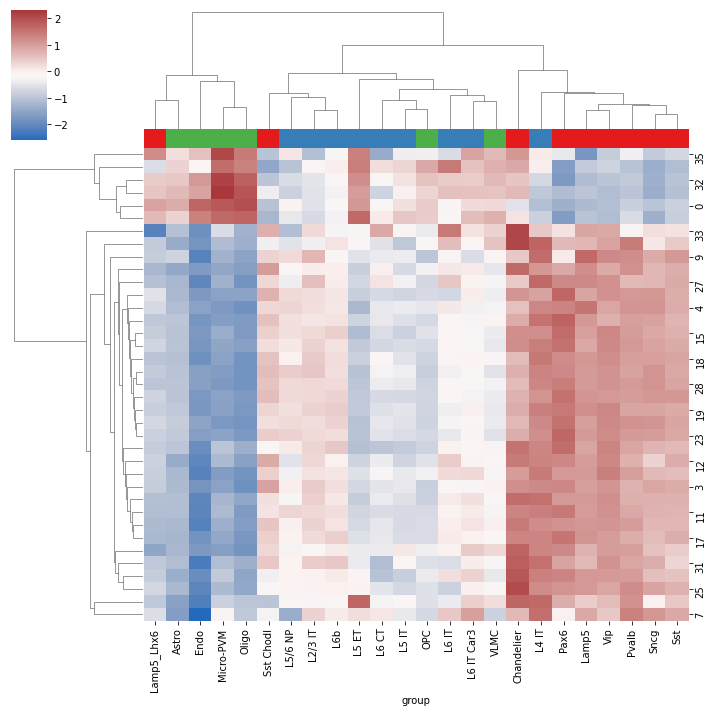

In [2097]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=True, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


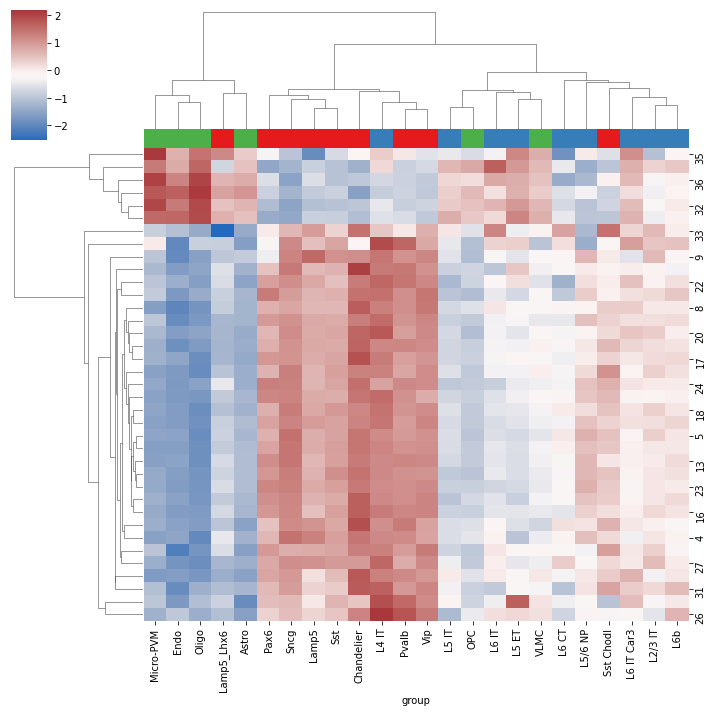

In [1793]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=True, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


In [1825]:
df_gene_tp_all_info_mean.index.get_level_values('classt')
import random

all_bins_p=all_bins_std[all_bins_std>=0.095].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
bin_random = random.sample(list(all_bins_pre), 500)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))

row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, bin_random ]
#features = np.vstack(mean_list).T

umap_2d = UMAP(n_components=2, init='random', random_state=10)

proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)

fig_2d.show()

In [2151]:
all_bins_std[all_bins_std >= 0.1]

1         0.176516
5         0.324837
6         0.281243
7         0.210348
8         0.378776
            ...   
287492    0.248101
287493    0.101327
287504    0.220812
287505    0.150498
287506    0.145846
Length: 55580, dtype: float32

In [2159]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.1].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features_sc)

In [2160]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



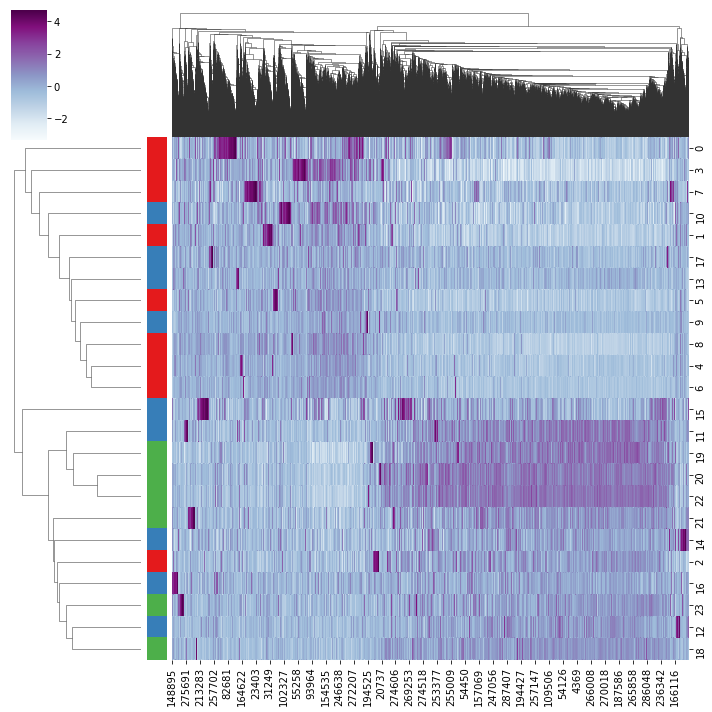

In [2161]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.1].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors,  z_score=1)


In [2098]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=50)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'},  size=([10]* df_gene_tp_all_info_mean.shape[0])
)



fig_2d.show()

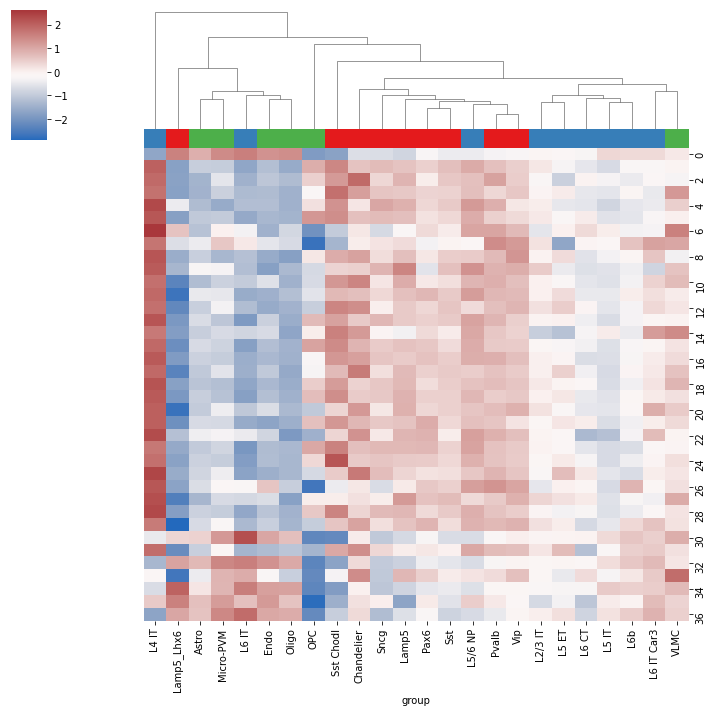

In [706]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


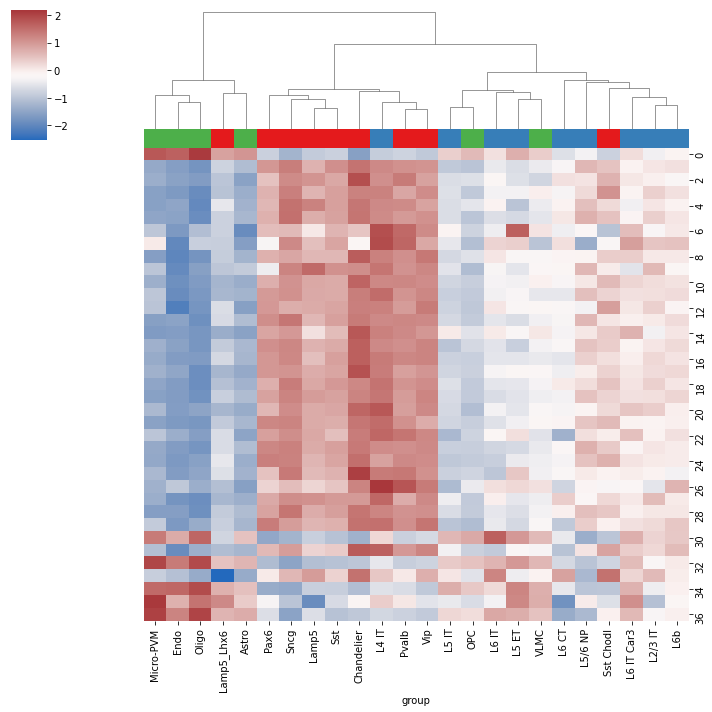

In [582]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


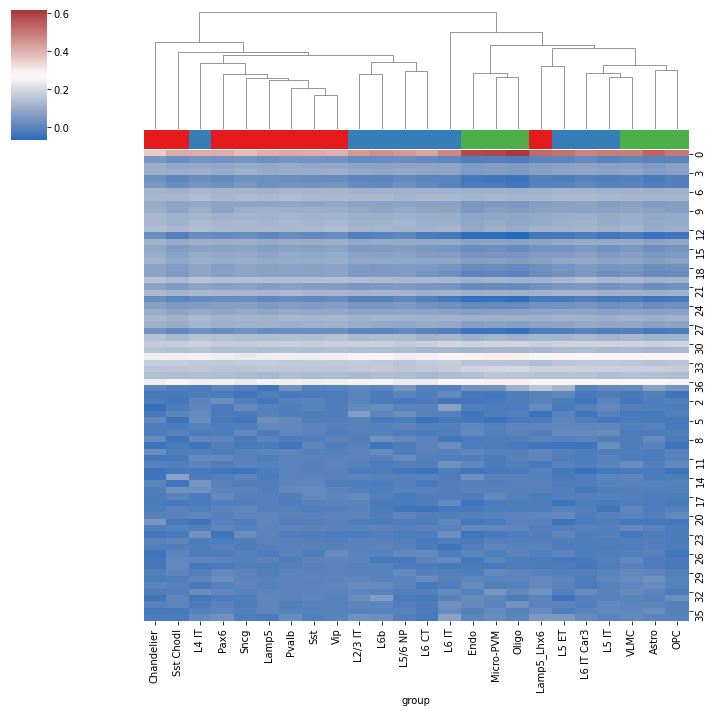

In [564]:
sns.clustermap(mean_list_df_merge.set_index('group').T, col_cluster=True, row_cluster=False, robust=False, col_colors=[row_colors], cmap='vlag')



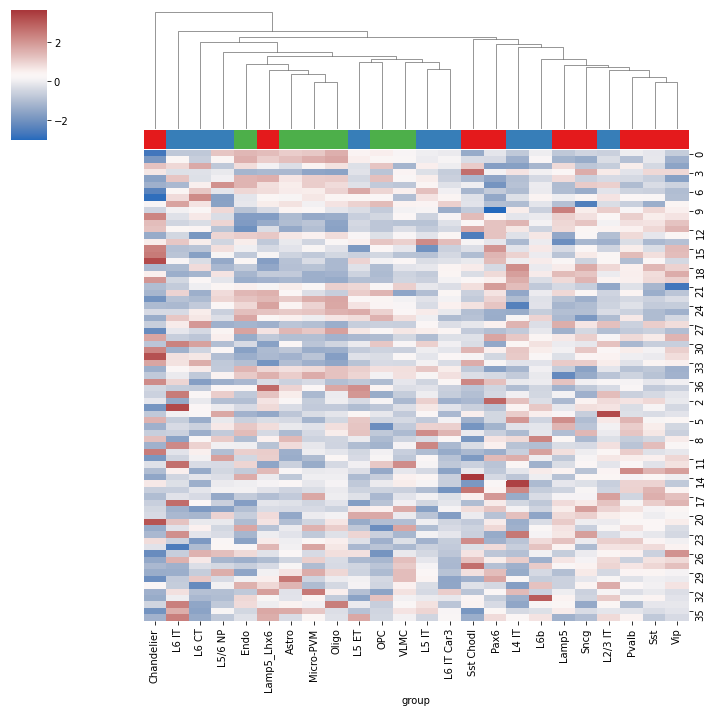

In [635]:
sns.clustermap(mean_list_df_merge.set_index('group').T, col_cluster=True, row_cluster=False, robust=False, col_colors=[row_colors], cmap='vlag', z_score=0)


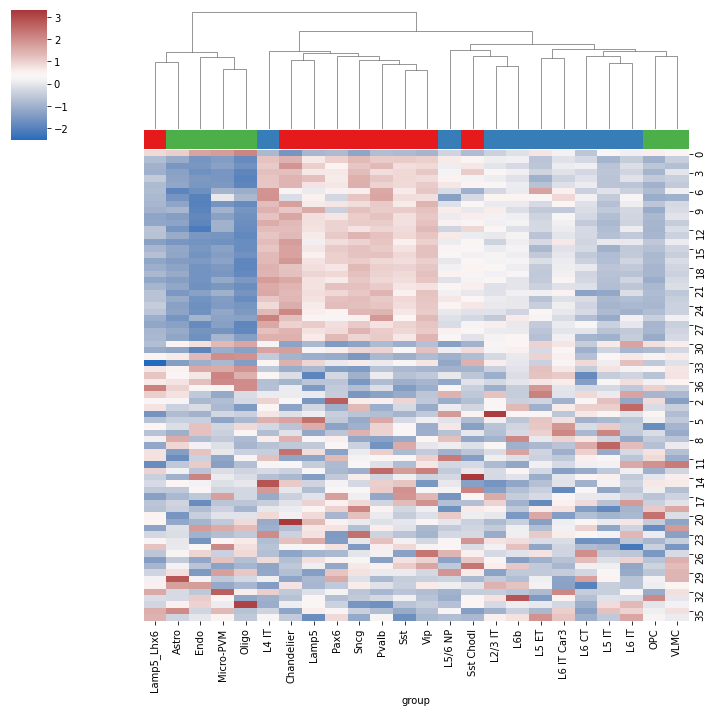

In [643]:
sns.clustermap(mean_list_df_merge.set_index('group').T, col_cluster=True, row_cluster=False, robust=False, col_colors=[row_colors], cmap='vlag', z_score=0)


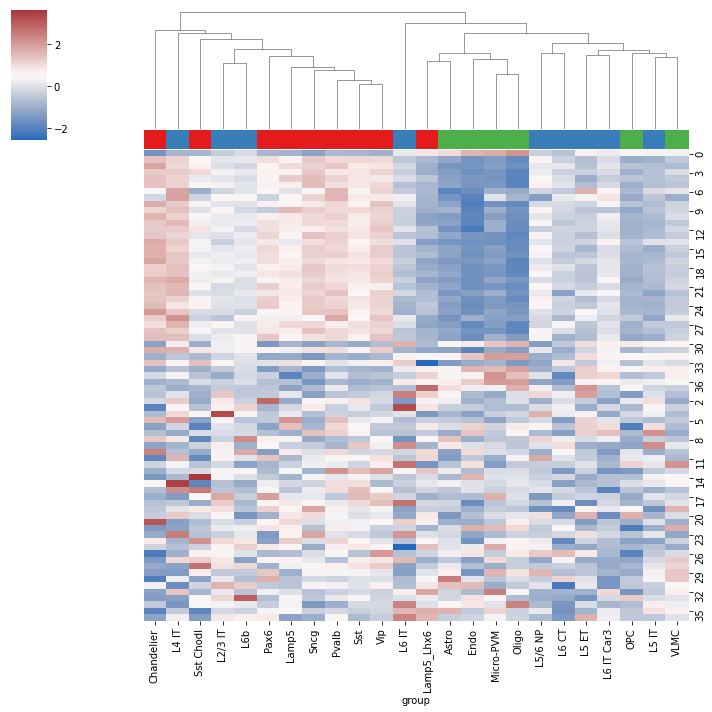

In [670]:
sns.clustermap(mean_list_df_merge.set_index('group').T, col_cluster=True, row_cluster=False, robust=False, col_colors=[row_colors], cmap='vlag', z_score=0)


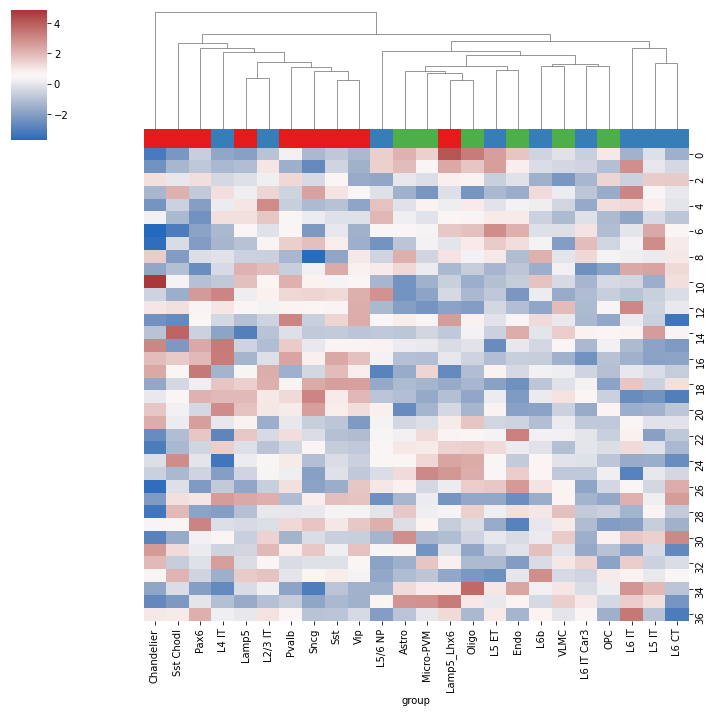

In [669]:
sns.clustermap(df_dj, col_cluster=True, row_cluster=False, robust=False, col_colors=[row_colors], cmap='vlag', z_score=0)


In [644]:
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))
 
mean_list_df_zcore = stats.zscore(mean_list_df,axis=1, nan_policy='omit')  
mean_list_df = pd.DataFrame(mean_list_df_zcore , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

mean_list_df_merge = mean_list_df.T.merge(pd.read_csv('./intra.csv'), left_on='group', right_on='group')

In [661]:
mean_list_df = pd.DataFrame(np.vstack(mean_list) , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))
 
mean_list_df_merge = mean_list_df.T.merge(pd.read_csv('./intra.csv'), left_on='group', right_on='group')

In [650]:
dj = pd.read_csv('./intra.csv').set_index('group').values + stats.zscore(mean_list_df,axis=1, nan_policy='omit').T

In [651]:
df_dj = pd.DataFrame(dj.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))
 

In [562]:
mean_list_df_merge

group         0         1         2         3         4         5  \
0   Chandelier  0.355069  0.044292  0.103318  0.109226  0.033248  0.048431   
1        Lamp5  0.404003  0.029778  0.092639  0.099061  0.029837  0.031613   
2   Lamp5_Lhx6  0.527262  0.002553  0.067351  0.070929 -0.008375 -0.005583   
3         Pax6  0.408916  0.036087  0.085768  0.099138  0.015677  0.030531   
4        Pvalb  0.412351  0.037248  0.096651  0.101749  0.027528  0.037472   
5         Sncg  0.378538  0.041975  0.094144  0.109856  0.034537  0.049870   
6          Sst  0.409316  0.037669  0.089742  0.102846  0.021837  0.035207   
7    Sst Chodl  0.410509  0.025952  0.088191  0.105786  0.007035  0.025803   
8          Vip  0.401455  0.036668  0.090659  0.106913  0.020947  0.040127   
9      L2/3 IT  0.440026  0.018914  0.079150  0.093476  0.004203  0.022009   
10       L4 IT  0.405730  0.039316  0.093380  0.109277  0.027961  0.041801   
11       L5 ET  0.515389  0.005200  0.072158  0.082350 -0.019598 -0.002687   
12       L5 IT  0.490538 -0.000300  0.071693  0.078048 -0.011369 -0.001297   
13     L5/6 NP  0.442287  0.028932  0.080979  0.091428  0.013672  0.030783   
14       L6 CT  0.425177  0.012154  0.081395  0.082924  0.000394  0.015512   
15       L6 IT  0.475354  0.008461  0.077625  0.082436  0.000495 -0.000819   
16  L6 IT Car3  0.479023  0.015680  0.080576  0.086471 -0.005730  0.011081   
17         L6b  0.459261  0.019780  0.076781  0.090410  0.000612  0.015860   
18       Astro  0.537775 -0.003770  0.060196  0.065467 -0.025569 -0.015129   
19        Endo  0.581809 -0.012932  0.060090  0.059781 -0.030408 -0.023334   
20   Micro-PVM  0.590336 -0.009528  0.062738  0.061746 -0.032029 -0.022114   
21         OPC  0.506304 -0.001473  0.072201  0.072450 -0.009175 -0.009691   
22       Oligo  0.614486 -0.016599  0.058898  0.055901 -0.040959 -0.032254   
23        VLMC  0.491244  0.008560  0.070420  0.087497 -0.007154  0.001159   

           6         7         8  ...        27        28        29        30  \
0   0.118177  0.126913  0.097042  ... -0.029603 -0.027243 -0.012947 -0.020683   
1   0.116433  0.130295  0.083071  ...  0.001747 -0.012971 -0.009214 -0.002185   
2   0.112891  0.123614  0.064105  ... -0.023091 -0.019631 -0.000216  0.011156   
3   0.118523  0.126361  0.084134  ... -0.000263 -0.025176  0.011093  0.025671   
4   0.122879  0.135666  0.089158  ... -0.016947 -0.008286  0.002892  0.001620   
5   0.118678  0.133457  0.085766  ... -0.006396 -0.010640  0.004702  0.002915   
6   0.118999  0.131853  0.082986  ...  0.002709 -0.005821  0.002611  0.004919   
7   0.111974  0.126661  0.079798  ...  0.009958  0.012566  0.006035 -0.010864   
8   0.121091  0.131643  0.092817  ...  0.004541 -0.002025  0.000209  0.004272   
9   0.115133  0.129957  0.075935  ...  0.004249 -0.005531 -0.004535  0.006612   
10  0.124228  0.137159  0.091535  ...  0.007431 -0.029006 -0.013199  0.007390   
11  0.123363  0.129432  0.072434  ... -0.023958 -0.020668 -0.005501  0.005545   
12  0.115849  0.125382  0.066246  ... -0.010362 -0.014225  0.001940  0.009826   
13  0.115381  0.121059  0.073883  ... -0.025092 -0.020082  0.013598  0.000220   
14  0.114566  0.128523  0.073797  ...  0.000890 -0.018661 -0.006711  0.018911   
15  0.114523  0.129167  0.076390  ...  0.014307 -0.028745 -0.012797 -0.004079   
16  0.118519  0.132182  0.079857  ... -0.024071 -0.027239 -0.008575 -0.014099   
17  0.116484  0.130150  0.075814  ... -0.026913 -0.003953 -0.004429 -0.003274   
18  0.108117  0.119883  0.059386  ... -0.015199 -0.013690  0.005587  0.035571   
19  0.109057  0.118019  0.049475  ... -0.027455 -0.022358 -0.014563  0.005473   
20  0.112178  0.127939  0.054814  ...  0.007117 -0.026186  0.013811 -0.001330   
21  0.112919  0.122483  0.067834  ... -0.024948 -0.024026 -0.010081 -0.000452   
22  0.111624  0.123671  0.052521  ... -0.013379 -0.019485  0.007561  0.004376   
23  0.116709  0.122899  0.072051  ...  0.010738 -0.003643  0.011228  0.021119   

          31        32        33

In [555]:
mean_list_df_merge.set_index('group').T

group  Chandelier     Lamp5  Lamp5_Lhx6      Pax6     Pvalb      Sncg  \
0        0.355069  0.404003    0.527262  0.408916  0.412351  0.378538   
1        0.044292  0.029778    0.002553  0.036087  0.037248  0.041975   
2        0.103318  0.092639    0.067351  0.085768  0.096651  0.094144   
3        0.109226  0.099061    0.070929  0.099138  0.101749  0.109856   
4        0.033248  0.029837   -0.008375  0.015677  0.027528  0.034537   
..            ...       ...         ...       ...       ...       ...   
32      -0.015083  0.004791    0.034059  0.009368  0.000036 -0.003893   
33      -0.032419  0.007158    0.001230 -0.016868  0.000782 -0.012625   
34      -0.005478  0.006120    0.000980 -0.004065 -0.012312 -0.019248   
35      -0.029245  0.007180    0.023326  0.003931 -0.003418 -0.006210   
36      -0.021024 -0.021646    0.051169  0.031954  0.021862 -0.014688   

group       Sst  Sst Chodl       Vip   L2/3 IT  ...     L6 CT     L6 IT  \
0      0.409316   0.410509  0.401455  0.440026  ...  0.425177  0.475354   
1      0.037669   0.025952  0.036668  0.018914  ...  0.012154  0.008461   
2      0.089742   0.088191  0.090659  0.079150  ...  0.081395  0.077625   
3      0.102846   0.105786  0.106913  0.093476  ...  0.082924  0.082436   
4      0.021837   0.007035  0.020947  0.004203  ...  0.000394  0.000495   
..          ...        ...       ...       ...  ...       ...       ...   
32     0.003360  -0.008319  0.000060  0.007187  ... -0.009463  0.017027   
33     0.006437   0.006172 -0.006885  0.021748  ... -0.025901 -0.002964   
34    -0.000811   0.007471 -0.000599  0.005848  ... -0.020085  0.034805   
35    -0.006001  -0.027979 -0.003923 -0.003467  ... -0.023721  0.021592   
36    -0.008231  -0.023847  0.001189  0.032768  ... -0.025488  0.071941   

group  L6 IT Car3       L6b     Astro      Endo  Micro-PVM       OPC  \
0        0.479023  0.459261  0.537775  0.581809   0.590336  0.506304   
1        0.015680  0.019780 -0.003770 -0.012932  -0.009528 -0.001473   
2        0.080576  0.076781  0.060196  0.060090   0.062738  0.072201   
3        0.086471  0.090410  0.065467  0.059781   0.061746  0.072450   
4       -0.005730  0.000612 -0.025569 -0.030408  -0.032029 -0.009175   
..            ...       ...       ...       ...        ...       ...   
32       0.021849 -0.003840  0.001292 -0.006601   0.044268 -0.019684   
33      -0.005330  0.061878 -0.006703  0.017338   0.006798  0.024380   
34      -0.010470  0.003349  0.007636  0.013098   0.001792 -0.007914   
35       0.001860 -0.004967  0.022575 -0.007395   0.015718 -0.007823   
36       0.016683  0.029020  0.001627  0.004474   0.019728 -0.001346   

group     Oligo      VLMC  
0      0.614486  0.491244  
1     -0.016599  0.008560  
2      0.058898  0.070420  
3      0.055901  0.087497  
4     -0.040959 -0.007154  
..          ...       ...  
32     0.013107  0.016597  
33    -0.017488 -0.001193  
34     0.035310  0.004348  
35    -0.005187  0.009317  
36     0.003945  0.012360  

[74 rows x 24 columns]

In [546]:
pd.read_csv('./intra.csv')

group         0         1         2         3         4         5  \
0   Chandelier  0.003995 -0.024027 -0.017034 -0.046611 -0.025369  0.012708   
1        Lamp5 -0.032301 -0.015640 -0.031241 -0.006280 -0.005015  0.024194   
2   Lamp5_Lhx6  0.158512 -0.001338 -0.004533  0.016159 -0.041202 -0.021939   
3         Pax6  0.002701 -0.022428  0.027766 -0.022295 -0.019179 -0.024432   
4        Pvalb  0.035983 -0.024431 -0.004265 -0.010829 -0.014942  0.011708   
5         Sncg -0.009143 -0.033342 -0.008294  0.014401 -0.023190 -0.034522   
6          Sst -0.007401 -0.021959 -0.001484 -0.000193 -0.017137 -0.012728   
7    Sst Chodl -0.013168 -0.029096 -0.031455 -0.016406  0.002745 -0.039386   
8          Vip -0.001940 -0.019149 -0.016566 -0.013011 -0.013287 -0.009146   
9      L2/3 IT  0.008205  0.000199 -0.002519  0.012622  0.063419 -0.003918   
10       L4 IT -0.021750 -0.016261  0.004143  0.006167  0.014363  0.021681   
11       L5 ET  0.127028  0.008212 -0.020685 -0.025898 -0.001642  0.005906   
12       L5 IT  0.015827 -0.017004  0.000204  0.011298 -0.002987 -0.029337   
13     L5/6 NP  0.039901 -0.003245 -0.029437 -0.004682  0.028247 -0.017838   
14       L6 CT -0.007197 -0.013716 -0.016432  0.002599 -0.004509 -0.041421   
15       L6 IT -0.005556  0.014739 -0.036656  0.071018 -0.007628 -0.028341   
16  L6 IT Car3 -0.001350 -0.025257 -0.034191 -0.007651 -0.033198 -0.014213   
17         L6b  0.003629 -0.022626 -0.019404  0.022351  0.002739 -0.025589   
18       Astro  0.072605 -0.009683 -0.011314 -0.011108 -0.026771 -0.023308   
19        Endo  0.037058 -0.026239 -0.029438 -0.012010 -0.036561 -0.027078   
20   Micro-PVM  0.039871 -0.030758 -0.025159 -0.019403 -0.016402 -0.038229   
21         OPC  0.047133 -0.034597 -0.012753 -0.020886 -0.011918 -0.024724   
22       Oligo  0.107714 -0.017353 -0.015092 -0.019497 -0.013095 -0.024325   
23        VLMC  0.011356 -0.025499 -0.031193 -0.010223 -0.024797 -0.023578   

           6         7         8  ...        27        28        29        30  \
0  -0.016683 -0.013446  0.016494  ... -0.029603 -0.027243 -0.012947 -0.020683   
1   0.012384 -0.018005  0.000741  ...  0.001747 -0.012971 -0.009214 -0.002185   
2   0.005427 -0.010394  0.002899  ... -0.023091 -0.019631 -0.000216  0.011156   
3  -0.015958 -0.013059  0.006603  ... -0.000263 -0.025176  0.011093  0.025671   
4   0.008225  0.010431 -0.016090  ... -0.016947 -0.008286  0.002892  0.001620   
5  -0.011706  0.013413 -0.022876  ... -0.006396 -0.010640  0.004702  0.002915   
6   0.002791  0.003276 -0.012627  ...  0.002709 -0.005821  0.002611  0.004919   
7  -0.023648 -0.005966 -0.035835  ...  0.009958  0.012566  0.006035 -0.010864   
8  -0.007947 -0.012681  0.004332  ...  0.004541 -0.002025  0.000209  0.004272   
9  -0.002354 -0.005998 -0.009581  ...  0.004249 -0.005531 -0.004535  0.006612   
10 -0.005468 -0.018920  0.009010  ...  0.007431 -0.029006 -0.013199  0.007390   
11  0.009556  0.010743 -0.006060  ... -0.023958 -0.020668 -0.005501  0.005545   
12  0.007355  0.022946 -0.010991  ... -0.010362 -0.014225  0.001940  0.009826   
13  0.003479 -0.014632  0.013245  ... -0.025092 -0.020082  0.013598  0.000220   
14 -0.008994 -0.022260 -0.001161  ...  0.000890 -0.018661 -0.006711  0.018911   
15 -0.007219 -0.012596 -0.031276  ...  0.014307 -0.028745 -0.012797 -0.004079   
16  0.007579  0.013995 -0.000724  ... -0.024071 -0.027239 -0.008575 -0.014099   
17 -0.004797 -0.007029  0.032455  ... -0.026913 -0.003953 -0.004429 -0.003274   
18 -0.004022 -0.019021  0.018153  ... -0.015199 -0.013690  0.005587  0.035571   
19  0.009195  0.012474 -0.021457  ... -0.027455 -0.022358 -0.014563  0.005473   
20 -0.005524 -0.010482 -0.013725  ...  0.007117 -0.026186  0.013811 -0.001330   
21 -0.025064 -0.014888 -0.022315  ... -0.024948 -0.024026 -0.010081 -0.000452   
22  0.005367  0.002057 -0.012757  ... -0.013379 -0.019485  0.007561  0.004376   
23 -0.010536 -0.018905 -0.013842  ...  0.010738 -0.003643  0.011228  0.021119   

          31        32        33

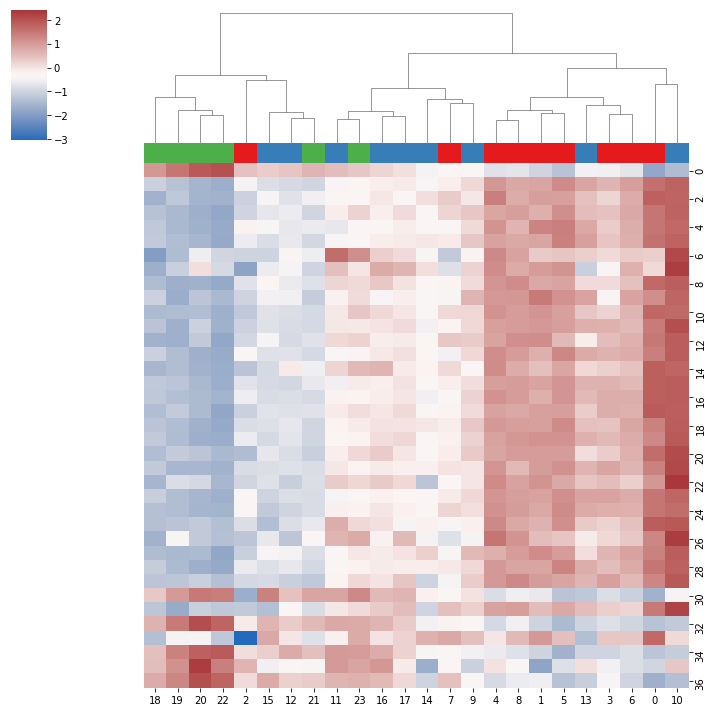

In [472]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


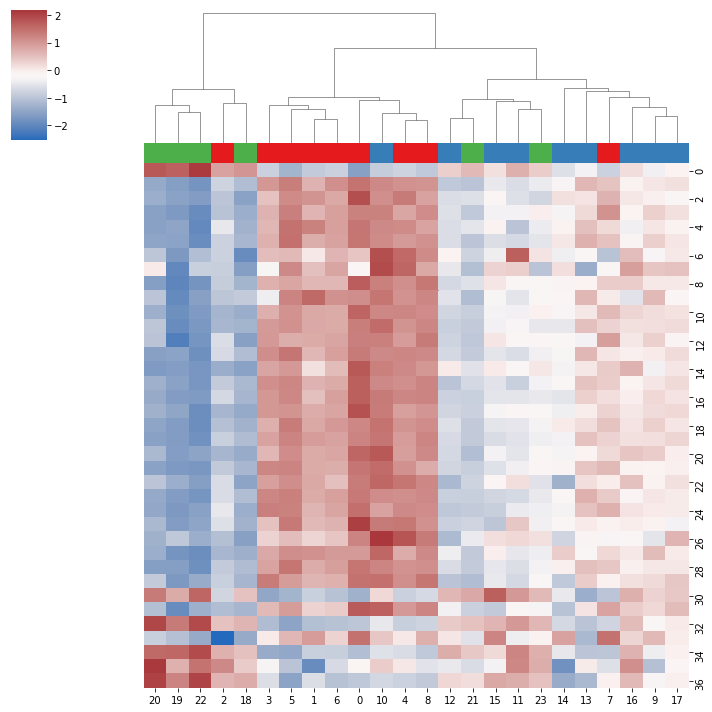

In [463]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


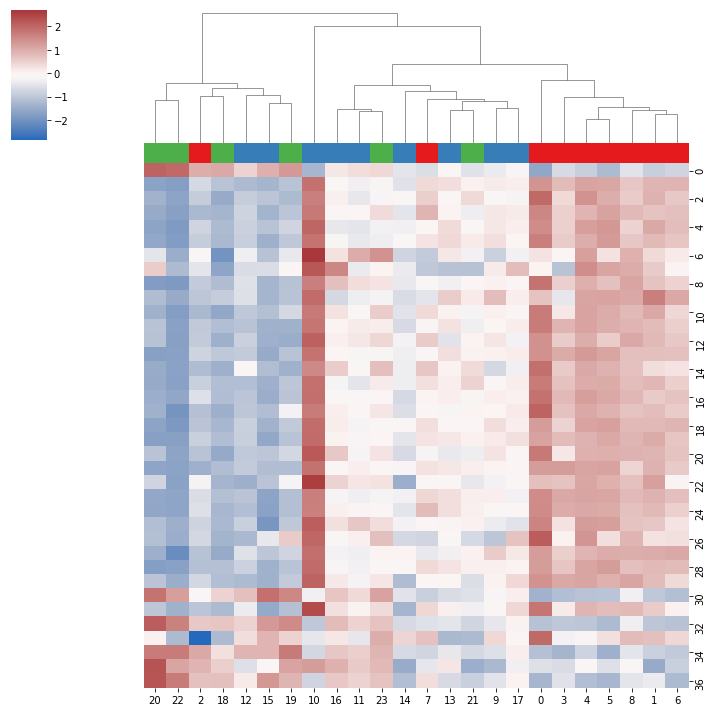

In [454]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


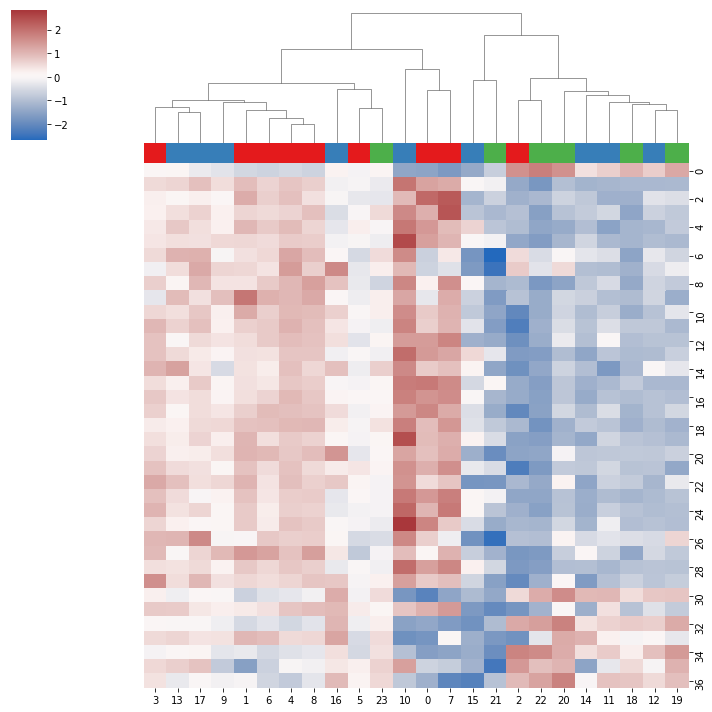

In [375]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


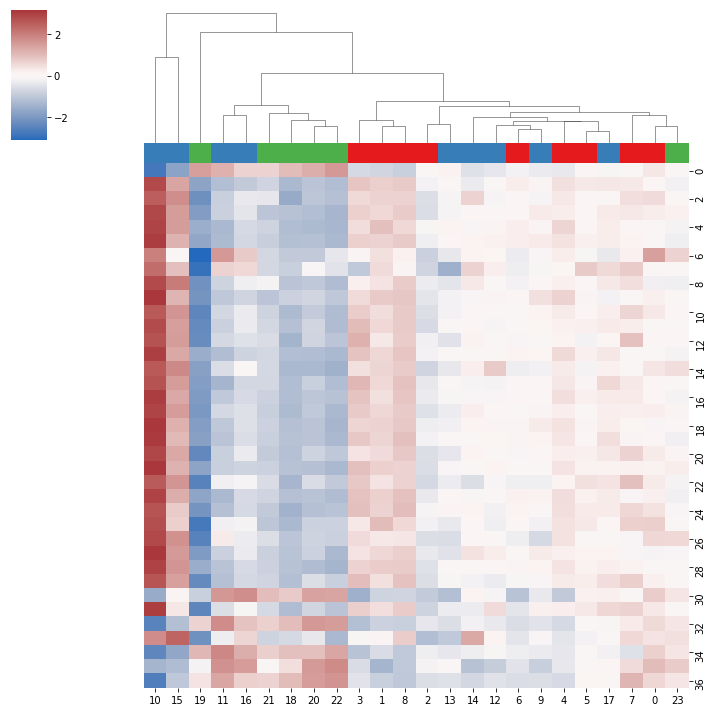

In [367]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


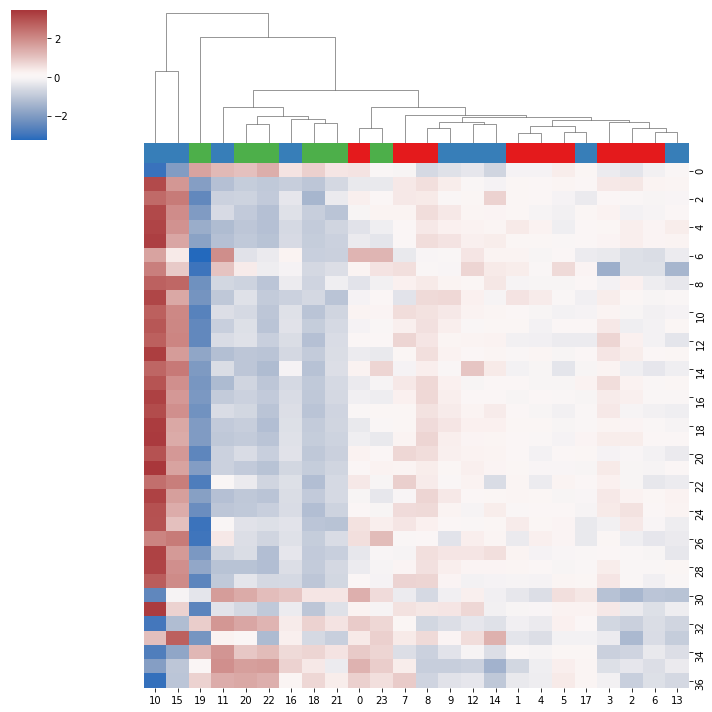

In [358]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


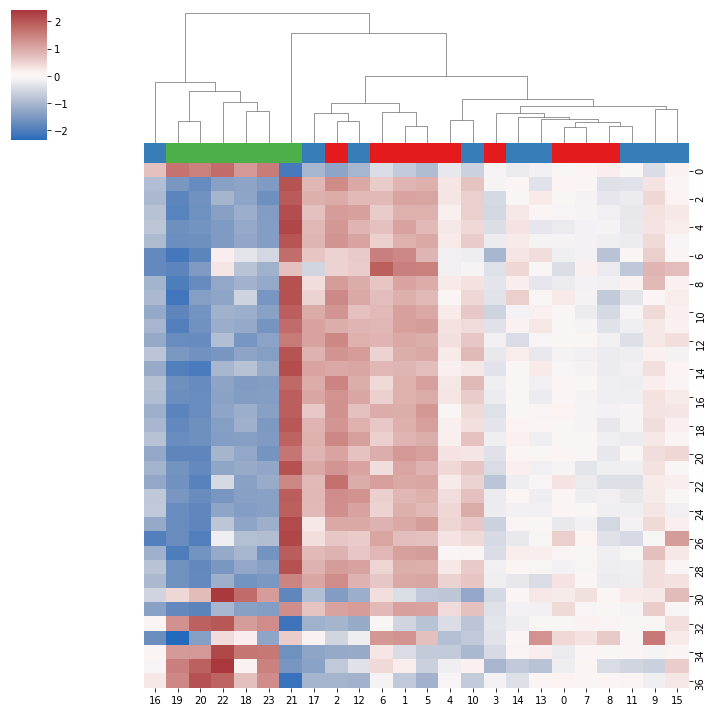

In [344]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


In [312]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


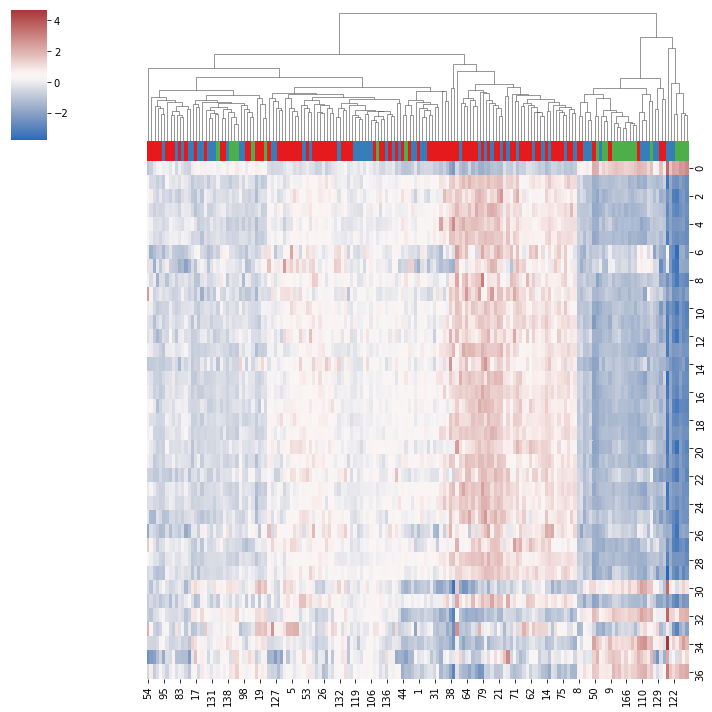

In [289]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


In [745]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
#features = np.vstack(mean_list).T
features =mean_list_df_merge.set_index('group')


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'},  size=([2]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()



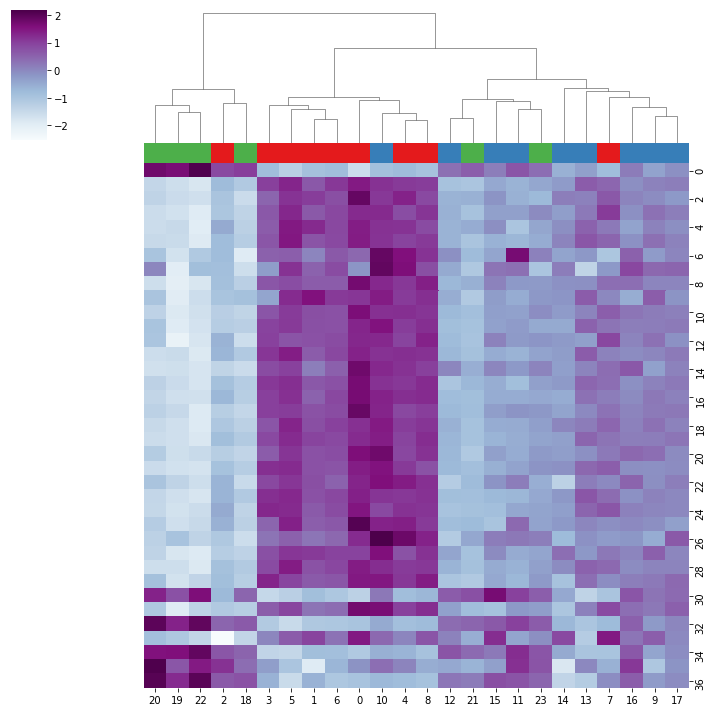

In [19]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='vlag')


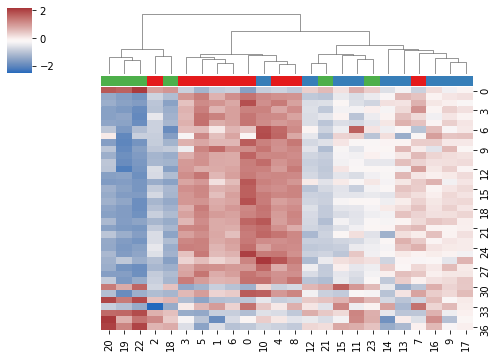

In [72]:
sns.clustermap(np.vstack(mean_list), cmap="vlag", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], figsize=(7, 5))



In [57]:
df_gene_tp_all_info_mean.index.get_level_values('group')

Index(['Chandelier', 'Lamp5', 'Lamp5_Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst',
       'Sst Chodl', 'Vip', 'L2/3 IT', 'L4 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Astro', 'Endo', 'Micro-PVM',
       'OPC', 'Oligo', 'VLMC'],
      dtype='object', name='group')

In [60]:
df_gene_tp_all_info_mean.index.get_level_values('classt')

Index(['GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic',
       'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'Glutamatergic',
       'Glutamatergic', 'Glutamatergic', 'Glutamatergic', 'Glutamatergic',
       'Glutamatergic', 'Glutamatergic', 'Glutamatergic', 'Glutamatergic',
       'Non-neuronal', 'Non-neuronal', 'Non-neuronal', 'Non-neuronal',
       'Non-neuronal', 'Non-neuronal'],
      dtype='object', name='classt')

In [82]:
cell_type_map = {'ITL23' : 'L2/3 IT' ,
'ITL4' : 'L4 IT' ,
'ITL5' : 'L5 IT' ,
'ITL6_1' : 'L6 IT' ,
'ITL6_2' : 'L6 IT CAR3' ,
'CT' : 'L6 CT' ,
'L6B' : 'L6B' ,
'NP' : 'L5/6 NP' ,
'ET' : 'L5 ET' ,
'SST_CHODL' : 'SST CHODL' ,
'SST' : 'SST' ,
'PVALB' : 'PVALB' ,
'PV_ChCs' : 'CHANDELIER' ,
'VIP' : 'VIP' ,
'SNCG' : 'SNCG' ,
'LAMP5' : 'LAMP5' ,
'LAMP5_LHX6' : 'LAMP5_LHX6' ,
'ASCT' : 'ASTRO' ,
'MGC' : 'MICRO-PVM' ,
'OPC' : 'OPC' ,
'OGC' : 'OLIGO' ,
'EC' : 'ENDO' ,
'Glutamatergic' : 'Glutamatergic',
'GABAergic' : 'GABAergic',
'Non-neuronal' : 'Non-neuronal'          
}

In [65]:
!pwd

/grid/gillis/home/lohia/notebooks_cre_v3


In [158]:
df_association = pd.read_csv("/grid/gillis/home/lohia/notebooks_cre_v3/association-Table 1.tsv", sep='\t')

In [159]:
df_names = pd.read_csv("/grid/gillis/home/lohia/notebooks_cre_v3/Sheet1-Table 1.tsv", sep='\t', names = ['corr_names', 'a', 'b', 'c'])



In [160]:
df_association = df_association.set_index('Unnamed: 0')

In [161]:
df_association = df_association.T

In [162]:
df_association['u_names'] = [cell_type_map[x].lower() if x in cell_type_map.keys() else "del" for x in df_names.index.tolist()]



In [166]:
order_list = [x.lower() for x in df_gene_tp_all_info_mean.index.get_level_values('group').tolist()]



In [245]:
col_index_list = [i for i,val in enumerate(df_gene_tp_all_info_mean.index.get_level_values('group').tolist()) if val.lower() in order_list ]



In [169]:
df_association = df_association.set_index('u_names')

In [171]:
order_list = [x for x in order_list if x in df_association.index.tolist() ]

In [175]:
df_association = df_association.T

In [181]:
df_association = df_association.astype('float')

In [182]:
df_association.loc[:, order_list]

u_names     chandelier     lamp5  lamp5_lhx6     pvalb      sncg       sst  \
Unnamed: 0                                                                   
M1            0.176753  0.137263    0.174072  0.135654  0.125380  0.201683   
M2            0.002366  0.000000    0.016480  0.000000  0.000000  0.013718   
M3            0.000000  0.000000    0.000635  0.000000  0.047237  0.000000   
M4            0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
M5            0.007587  0.000000    0.000000  0.000000  0.000000  0.022749   
M6            0.000000  0.000000    0.000000  0.001123  0.000000  0.000000   
M7            0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
M8            0.000000  0.000000    0.000000  0.022401  0.000000  0.000000   
M9            0.000000  0.022917    0.000000  0.080349  0.000000  0.000000   
M10           0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
M11           0.000000  0.000000    0.005386  0.000000  0.004149  0.000000   
M12           0.000000  0.000000    0.000594  0.000000  0.000000  0.000000   
M13           0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
M14           0.000000  0.023744    0.000000  0.000000  0.000000  0.000000   
M15           0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
M16           0.000000  0.000000    0.043487  0.000000  0.079367  0.147235   
M17           0.000000  0.000000    0.000000  0.310365  0.000000  0.542462   
M18           0.764587  0.000000    0.009571  0.350746  0.000000  0.000000   
M19           0.016481  0.000000    0.028308  0.000000  0.249299  0.008472   
M20           0.000000  0.635880    0.000000  0.000000  0.422241  0.000000   
M21           0.017366  0.180197    0.683050  0.000000  0.000000  0.006084   
M22           0.000000  0.000000    0.007627  0.000000  0.013480  0.000000   
M23           0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
M24           0.000000  0.000000    0.000000  0.000000  0.001876  0.022230   
M25           0.000000  0.000000    0.000736  0.000000  0.015438  0.004585   
M26           0.003363  0.000000    0.000000  0.000000  0.000000  0.017364   
M27           0.000000  0.000000    0.000000  0.000000  0.000000  0.000000   
M28           0.000000  0.000000    0.023633  0.072664  0.000000  0.000000   
M29           0.008937  0.000000    0.001703  0.000000  0.017328  0.013418   
M30           0.000000  0.000000    0.000185  0.003023  0.013351  0.000000   
M31           0.000000  0.000000    0.000000  0.000932  0.002590  0.000000   
M32           0.000000  0.000000    0.000000  0.001465  0.000000  0.000000   
M33           0.000000  0.000000    0.002628  0.016196  0.003352  0.000000   
M34           0.002560  0.000000    0.000000  0.000000  0.001195  0.000000   
M35           0.000000  0.000000    0.000000  0.000966  0.000000  0.000000   
M36           0.000000  0.000000    0.001058  0.000000  0.001420  0.000000   
M37           0.000000  0.000000    0.000847  0.004117  0.002295  0.000000   

u_names        sst chodl       vip   l2/3 it     l4 it  ...   l5/6 np  \
Unnamed: 0                                              ...             
M1          1.171530e-01  0.170775  0.064318  0.086768  ...  0.099468   
M2          0.000000e+00  0.000000  0.000000  0.000000  ...  0.000000   
M3          0.000000e+00  0.000000  0.387837  0.000000  ...  0.000000   
M4          0.000000e+00  0.000000  0.000000  0.000000  ...  0.000000   
M5          0.000000e+00  0.000000  0.016212  0.700024  ...  0.019606   
M6          4.374660e-03  0.000000  0.000000  0.000000  ...  0.002604   
M7          0.000000e+00  0.000000  0.249700  0.000000  ...  0.005292   
M8          0.000000e+00  0.000000  0.000000  0.000000  ...  0.000000   
M9          1.383740e-03  0.031473  0.262317  0.198753  ...  0.000000   
M10         0.000000e+00  0.000000  0.000000  0.000000  ...  0.006665   
M11         0.000000e+00  0.000000  0.000000  0.008192  ...  0.000000   
M12     

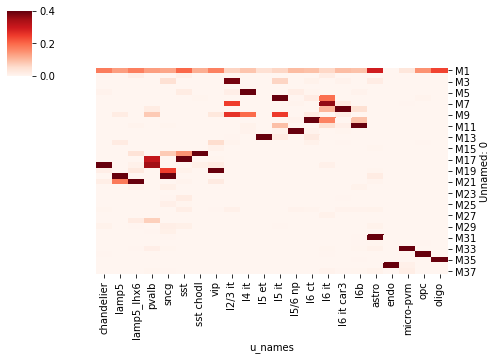

In [241]:
sns.clustermap(df_association.loc[:, order_list], cmap="Reds", col_cluster=False, row_cluster=False, robust=False, figsize=(7, 5), vmax=0.4)


In [217]:
tmp_list = [x.lower() for x in df_gene_tp_all_info_mean.index.get_level_values('group').tolist()]

In [218]:
tmp_list.index('chandelier')

0

In [ ]:
[]

In [215]:
order_list

['chandelier',
 'lamp5',
 'lamp5_lhx6',
 'pvalb',
 'sncg',
 'sst',
 'sst chodl',
 'vip',
 'l2/3 it',
 'l4 it',
 'l5 et',
 'l5 it',
 'l5/6 np',
 'l6 ct',
 'l6 it',
 'l6 it car3',
 'l6b',
 'astro',
 'endo',
 'micro-pvm',
 'opc',
 'oligo']

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in 

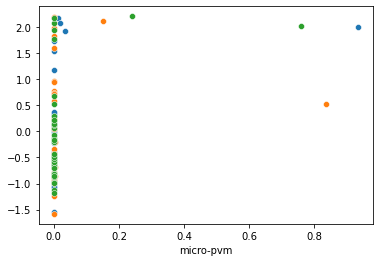

In [238]:
#for i in range(0,len(order_list)):
for i in range(19,len(order_list)):
    sns.scatterplot(df_association[order_list[i]], tmp[:,tmp_list.index(order_list[i])])

In [209]:
tmp= np.vstack(mean_list)

In [225]:
tmp.shape

(37, 24)

In [235]:
tmp = stats.zscore(tmp, axis=0)

In [257]:
df_gene_plot = pd.DataFrame(np.vstack(mean_list)[:, col_index_list] ,  index=df_association.index.tolist(), columns = order_list)

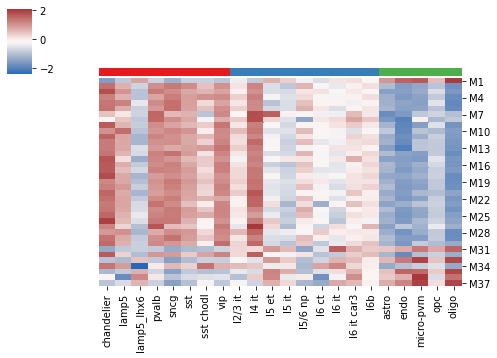

In [258]:
sns.clustermap(df_gene_plot, cmap="vlag", col_cluster=False, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors[col_index_list]], figsize=(7, 5))


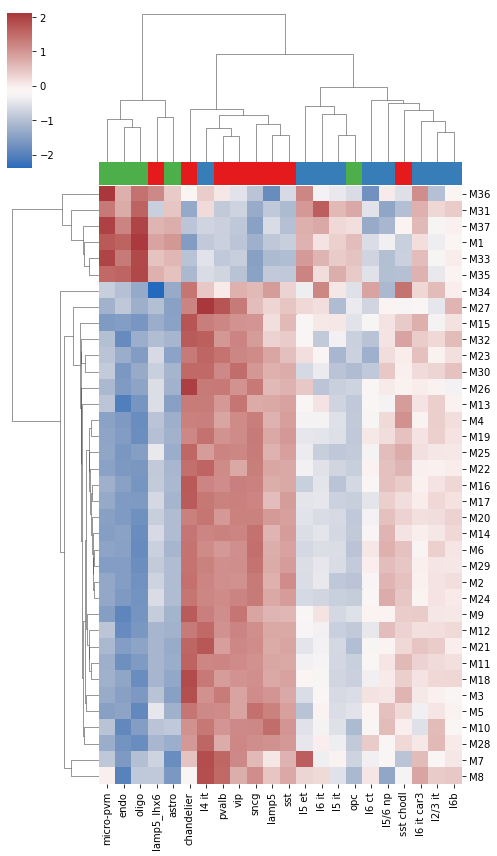

In [270]:
sns.clustermap(df_gene_plot, cmap="vlag", col_cluster=True, row_cluster=True, robust=False, z_score=0, col_colors=[row_colors[col_index_list]], figsize=(7, 12))


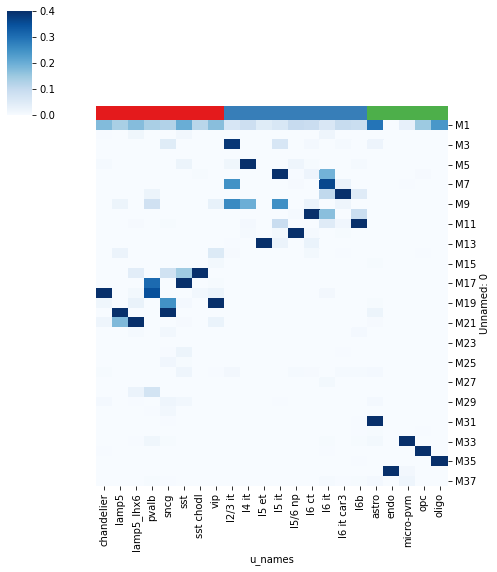

In [268]:
sns.clustermap(df_association.loc[:, order_list], cmap="Blues", col_cluster=False, row_cluster=False, robust=False, figsize=(7, 8), vmax=0.4, col_colors=[row_colors[col_index_list]])


In [192]:
df_association

u_names          del       del   l2/3 it       del     l4 it       del  \
Unnamed: 0                                                               
M1          0.094855  0.064348  0.064318  0.079991  0.086768  0.072225   
M2          0.839227  0.221976  0.000000  0.000000  0.000000  0.000000   
M3          0.000000  0.608060  0.387837  0.000000  0.000000  0.000000   
M4          0.000000  0.000000  0.000000  0.781852  0.000000  0.000000   
M5          0.000167  0.000000  0.016212  0.000000  0.700024  0.337968   
M6          0.000000  0.009438  0.000000  0.000000  0.000000  0.467059   
M7          0.014253  0.000000  0.249700  0.013923  0.000000  0.000000   
M8          0.000000  0.009847  0.000000  0.018284  0.000000  0.120482   
M9          0.004773  0.000000  0.262317  0.068765  0.198753  0.000000   
M10         0.000000  0.033335  0.000000  0.000000  0.000000  0.000000   
M11         0.000000  0.000032  0.000000  0.000000  0.008192  0.000000   
M12         0.000000  0.015136  0.000000  0.003046  0.006263  0.000000   
M13         0.000610  0.000000  0.002507  0.007279  0.000000  0.000000   
M14         0.028986  0.000000  0.005720  0.011343  0.000000  0.000000   
M15         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M16         0.002721  0.000000  0.000000  0.005722  0.000000  0.000000   
M17         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M18         0.000000  0.015002  0.000000  0.000000  0.000000  0.000000   
M19         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M20         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M21         0.000000  0.000876  0.000000  0.000000  0.000000  0.000000   
M22         0.000000  0.001302  0.000000  0.000368  0.000000  0.000000   
M23         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M24         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M25         0.000000  0.003239  0.000000  0.000000  0.000000  0.000000   
M26         0.014406  0.000000  0.011389  0.000000  0.000000  0.000000   
M27         0.000000  0.014412  0.000000  0.001794  0.000000  0.000000   
M28         0.000000  0.000000  0.000000  0.004564  0.000000  0.000000   
M29         0.000000  0.000213  0.000000  0.000000  0.000000  0.000000   
M30         0.000000  0.000347  0.000000  0.000000  0.000000  0.000000   
M31         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M32         0.000000  0.000000  0.000000  0.000000  0.000000  0.000778   
M33         0.000000  0.000339  0.000000  0.000000  0.000000  0.001115   
M34         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M35         0.000000  0.000000  0.000000  0.000000  0.000000  0.000373   
M36         0.000000  0.001039  0.000000  0.000000  0.000000  0.000000   
M37         0.000000  0.001058  0.000000  0.003069  0.000000  0.000000   

u_names        l5 it     l6 it  l6 it car3       del  ...       del       del  \
Unnamed: 0                                            ...                       
M1          0.063734  0.061692    0.097865  0.050948  ...  0.072848  0.140784   
M2          0.000000  0.019212    0.000000  0.000000  ...  0.071346  0.000000   
M3          0.064758  0.000000    0.006254  0.000000  ...  0.000000  0.000000   
M4          0.000000  0.000000    0.000000  0.000000  ...  0.000000  0.000000   
M5          0.000000  0.000000    0.000000  0.018576  ...  0.000000  0.000000   
M6          0.489155  0.193185    0.000000  0.000000  ...  0.000000  0.000000   
M7          0.000000  0.365523    0.023593  0.000000  ...  0.000000  0.000000   
M8          0.000000  0.106299    0.820072  0.086381  ...  0.025996  0.000000   
M9          0.252500  0.000000    0.019195  0.708481  ...  0.000739  0.000000   
M10         0.000000  0.169739    0.000000  0.005815  ...  0.000000  0.000000   
M11         0.093795  0.049107    0.015113  0.000000  ...  0.022494  0.000000   
M12         0.009482  0.000000    0.004050  0.000000  ...  0

In [ ]:
sns.scatterplot("L")

In [53]:
np.vstack(mean_list)

array([[ 3.55069220e-01,  4.04003471e-01,  5.27261734e-01,
         4.08916384e-01,  4.12350863e-01,  3.78538489e-01,
         4.09316301e-01,  4.10509497e-01,  4.01454836e-01,
         4.40026194e-01,  4.05729562e-01,  5.15388787e-01,
         4.90538210e-01,  4.42286730e-01,  4.25176919e-01,
         4.75353569e-01,  4.79023218e-01,  4.59261090e-01,
         5.37774861e-01,  5.81808746e-01,  5.90335965e-01,
         5.06303549e-01,  6.14485502e-01,  4.91244495e-01],
       [ 4.42915708e-02,  2.97776014e-02,  2.55271490e-03,
         3.60868499e-02,  3.72480974e-02,  4.19746637e-02,
         3.76691036e-02,  2.59520598e-02,  3.66680548e-02,
         1.89142115e-02,  3.93159427e-02,  5.19959908e-03,
        -2.99612351e-04,  2.89320312e-02,  1.21540036e-02,
         8.46052449e-03,  1.56802516e-02,  1.97799783e-02,
        -3.77023243e-03, -1.29321795e-02, -9.52842180e-03,
        -1.47340482e-03, -1.65986754e-02,  8.55991803e-03],
       [ 1.03317738e-01,  9.26391631e-02,  6.73507527e

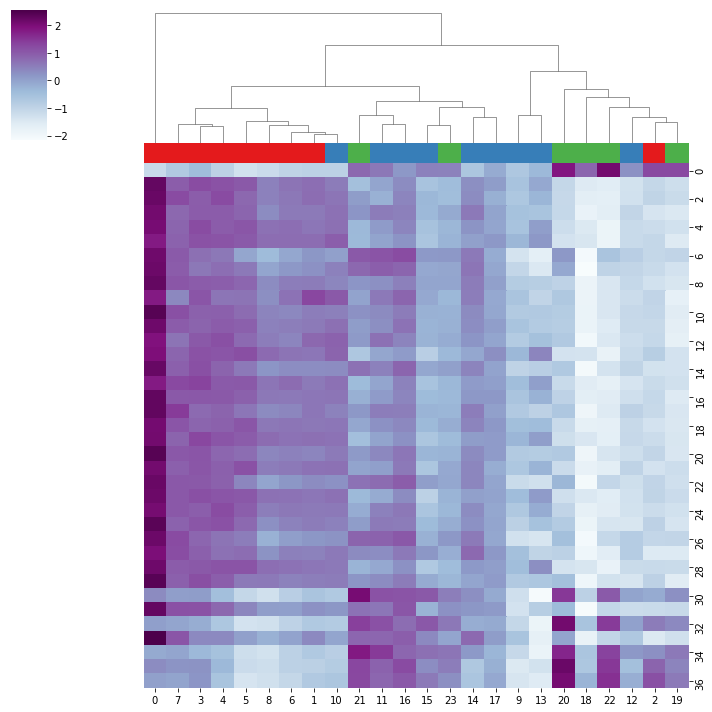

In [19]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors])


In [747]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'},  size=([10]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [33]:
import random

all_bins_p=all_bins_std[all_bins_std>=0.095].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
#bin_random = random.sample(list(all_bins_pre), 50000)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, all_bins]
#features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [47]:
import random

all_bins_p=all_bins_std[all_bins_std>=0.095].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
bin_random = random.sample(list(all_bins_pre), 5)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, bin_random ]
#features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [51]:
sns.clustermap(df_gene_tp_all_info_mean.dropna(axis=1).loc[:, bin_random ], cmap="BuPu", col_cluster=True, row_cluster=True, robust=False, row_colors=[row_colors])


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



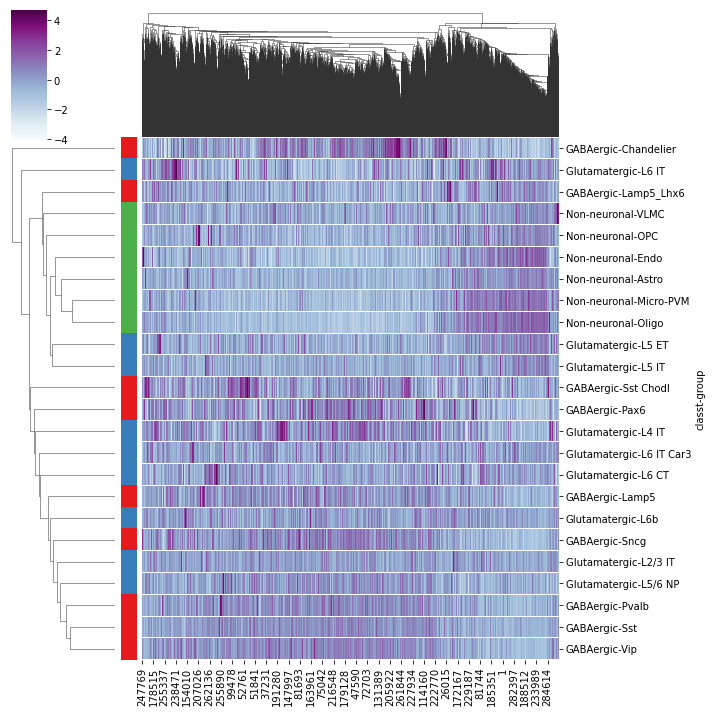

In [277]:
sns.clustermap(df_gene_tp_all_info_mean.dropna(axis=1).loc[:, all_bins ], cmap="BuPu", col_cluster=True, row_cluster=True, robust=False, row_colors=[row_colors], z_score=1)


In [280]:
pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv').drop_duplicates(['cell_type'])


group      cell_type  rank    gene  recurrence     auroc  fold_change  \
0      all      GABAergic     1    Gad1           7  0.941159   116.960472   
1000   all  Glutamatergic     1  Arpp21           7  0.975092     9.088639   
2000   all   Non-Neuronal     1      Qk           7  0.896552    17.743711   

      fold_change_detection   expression  precision    recall  \
0                  9.289078   820.463486   0.659089  0.894510   
1000               2.043554  1381.680094   0.857382  0.997152   
2000               1.622649  1620.810999   0.086534  0.891635   

      population_size  n_datasets  scSS  snSS  scCv2  snCv2  snCv3M  scCv3  \
0        10207.000000           7  True  True   True   True    True   True   
1000     49843.000000           7  True  True   True   True    True   True   
2000      8908.857143           7  True  True   True   True    True   True   

      snCv3Z  
0       True  
1000    True  
2000    True

In [284]:
pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv').drop_duplicates(['cell_type'])['cell_type'].tolist()


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



['L2/3 IT_1',
 'L2/3 IT_2',
 'L2/3 IT_3',
 'L4/5 IT_1',
 'L4/5 IT_2',
 'L5 IT_1',
 'L5 IT_2',
 'L5 IT_3',
 'L5 IT_4',
 'L5 PT_1',
 'L5 PT_2',
 'L5 PT_3',
 'L5 PT_4',
 'L5/6 NP CT',
 'L5/6 NP_1',
 'L5/6 NP_2',
 'L5/6 NP_3',
 'L6 CT Cpa6',
 'L6 CT Gpr139',
 'L6 CT Grp',
 'L6 CT Kit_1',
 'L6 CT Kit_2',
 'L6 CT Pou3f2',
 'L6 IT_1',
 'L6 IT_2',
 'L6b Col6a1',
 'L6b Kcnip1',
 'L6b Ror1',
 'L6b Shisa6_1',
 'L6b Shisa6_2',
 'Lamp5 Egln3_1',
 'Lamp5 Egln3_2',
 'Lamp5 Egln3_3',
 'Lamp5 Lhx6',
 'Lamp5 Pax6',
 'Lamp5 Pdlim5_1',
 'Lamp5 Pdlim5_2',
 'Lamp5 Slc35d3',
 'Pvalb Calb1_1',
 'Pvalb Calb1_2',
 'Pvalb Egfem1',
 'Pvalb Gabrg1',
 'Pvalb Gpr149',
 'Pvalb Il1rapl2',
 'Pvalb Kank4',
 'Pvalb Reln',
 'Pvalb Vipr2_1',
 'Pvalb Vipr2_2',
 'Sncg Calb1_1',
 'Sncg Calb1_2',
 'Sncg Col14a1',
 'Sncg Npy2r',
 'Sncg Slc17a8',
 'Vip Sncg',
 'Sst C1ql3_1',
 'Sst C1ql3_2',
 'Sst Calb2',
 'Sst Crhr2_1',
 'Sst Crhr2_2',
 'Sst Etv1',
 'Sst Hpse',
 'Sst Htr1a',
 'Sst Myh8_1',
 'Sst Myh8_2',
 'Sst Myh8_3',
 'Sst Pap

In [44]:
import random

all_bins_p=all_bins_std[all_bins_std>=0.095].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
#bin_random = random.sample(list(all_bins_pre), 50000)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, all_bins]
#features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [46]:
import random

all_bins_p=all_bins_std[all_bins_std>=0.095].index.tolist()
all_bins_pre = df_gene_tp_all_info_mean.dropna(axis=1).columns.intersection(all_bins_p)
all_bins_pre = all_bins_pre.intersection(all_bins)
bin_random = random.sample(list(all_bins_pre), 50)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.dropna(axis=1).loc[:, bin_random ]
#features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [47]:
#proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [45]:
#proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}, size=([15]* df_gene_tp_all_info_mean.shape[0])
)


fig_2d.show()

In [ ]:
15

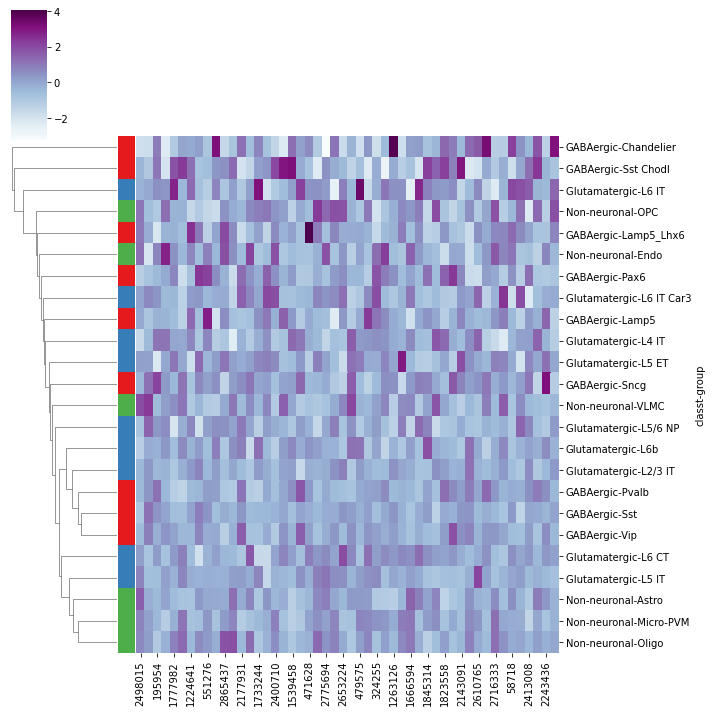

In [48]:
sns.clustermap(df_gene_tp_all_info_mean.dropna(axis=1).loc[:, bin_random ], cmap="BuPu", col_cluster=False, row_cluster=True, robust=False, z_score=1, row_colors=[row_colors])


In [82]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [81]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = np.vstack(mean_list).T


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [76]:
features.shape

(36, 24)

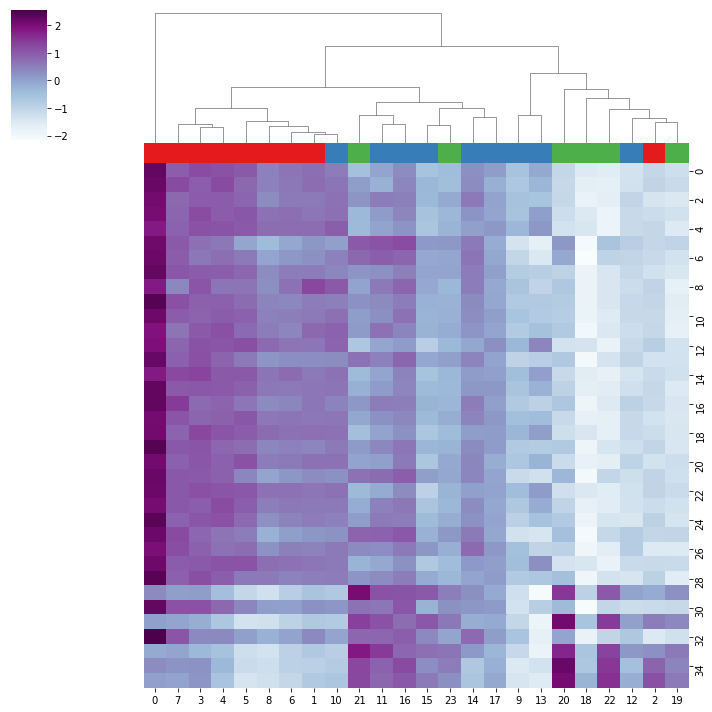

In [71]:
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors])


In [68]:
df_gene_tp_all_info_mean.reset_index()

classt       group         0         1         2         3  \
0       GABAergic  Chandelier -1.091419 -1.091419 -1.091419 -1.091419   
1       GABAergic       Lamp5 -0.954414 -0.954414 -0.954414 -0.954414   
2       GABAergic  Lamp5_Lhx6 -0.846578 -0.846578 -0.846578 -0.846578   
3       GABAergic        Pax6 -1.004080 -1.004080 -1.004080 -1.004080   
4       GABAergic       Pvalb -1.002590 -1.002590 -1.002590 -1.002590   
5       GABAergic        Sncg -0.968221 -0.968221 -0.968221 -0.968221   
6       GABAergic         Sst -0.961989 -0.961989 -0.961989 -0.961989   
7       GABAergic   Sst Chodl -1.014591 -1.014591 -1.014591 -1.014591   
8       GABAergic         Vip -0.947231 -0.947231 -0.947231 -0.947231   
9   Glutamatergic     L2/3 IT -0.867302 -0.867302 -0.867302 -0.867302   
10  Glutamatergic       L4 IT -0.947825 -0.947825 -0.947825 -0.947825   
11  Glutamatergic       L5 ET -0.982317 -0.982317 -0.982317 -0.982317   
12  Glutamatergic       L5 IT -0.844985 -0.844985 -0.844985 -0.844985   
13  Glutamatergic     L5/6 NP -0.882583 -0.882583 -0.882583 -0.882583   
14  Glutamatergic       L6 CT -0.964222 -0.964222 -0.964222 -0.964222   
15  Glutamatergic       L6 IT -0.924016 -0.924016 -0.924016 -0.924016   
16  Glutamatergic  L6 IT Car3 -0.965146 -0.965146 -0.965146 -0.965146   
17  Glutamatergic         L6b -0.930758 -0.930758 -0.930758 -0.930758   
18   Non-neuronal       Astro -0.805632 -0.805632 -0.805632 -0.805632   
19   Non-neuronal        Endo -0.852656 -0.852656 -0.852656 -0.852656   
20   Non-neuronal   Micro-PVM -0.886404 -0.886404 -0.886404 -0.886404   
21   Non-neuronal         OPC -0.921080 -0.921080 -0.921080 -0.921080   
22   Non-neuronal       Oligo -0.851876 -0.851876 -0.851876 -0.851876   
23   Non-neuronal        VLMC -0.910679 -0.910679 -0.910679 -0.910679   

           4         5         6         7  ...   2875002   2875003   2875004  \
0  -1.091419 -1.091419 -1.091419 -1.091419  ... -1.095077 -1.095077 -1.095077   
1  -0.954414 -0.954414 -0.954414 -0.954414  ... -0.973485 -0.973485 -0.973485   
2  -0.846578 -0.846578 -0.846578 -0.846578  ... -0.855263 -0.855263 -0.855263   
3  -1.004080 -1.004080 -1.004080 -1.004080  ... -0.996868 -0.996868 -0.996868   
4  -1.002590 -1.002590 -1.002590 -1.002590  ... -1.006892 -1.006892 -1.006892   
5  -0.968221 -0.968221 -0.968221 -0.968221  ... -0.978159 -0.978159 -0.978159   
6  -0.961989 -0.961989 -0.961989 -0.961989  ... -0.962013 -0.962013 -0.962013   
7  -1.014591 -1.014591 -1.014591 -1.014591  ... -0.996758 -0.996758 -0.996758   
8  -0.947231 -0.947231 -0.947231 -0.947231  ... -0.944837 -0.944837 -0.944837   
9  -0.867302 -0.867302 -0.867302 -0.867302  ... -0.866676 -0.866676 -0.866676   
10 -0.947825 -0.947825 -0.947825 -0.947825  ... -0.958794 -0.958794 -0.958794   
11 -0.982317 -0.982317 -0.982317 -0.982317  ... -0.987965 -0.987965 -0.987965   
12 -0.844985 -0.844985 -0.844985 -0.844985  ... -0.844492 -0.844492 -0.844492   
13 -0.882583 -0.882583 -0.882583 -0.882583  ... -0.878252 -0.878252 -0.878252   
14 -0.964222 -0.964222 -0.964222 -0.964222  ... -0.969003 -0.969003 -0.969003   
15 -0.924016 -0.924016 -0.924016 -0.924016  ... -0.891440 -0.891440 -0.891440   
16 -0.965146 -0.965146 -0.965146 -0.965146  ... -0.983997 -0.983997 -0.983997   
17 -0.930758 -0.930758 -0.930758 -0.930758  ... -0.922946 -0.922946 -0.922946   
18 -0.805632 -0.805632 -0.805632 -0.805632  ... -0.800982 -0.800982 -0.800982   
19 -0.852656 -0.852656 -0.852656 -0.852656  ... -0.845665 -0.845665 -0.845665   
20 -0.886404 -0.886404 -0.886404 -0.886404  ... -0.889262 -0.889262 -0.889262   
21 -0.921080 -0.921080 -0.921080 -0.921080  ... -0.938689 -0.938689 -0.938689   
22 -0.851876 -0.851876 -0.851876 -0.851876  ... -0.833301 -0.833301 -0.833301   
23 -0.910679 -0.910679 -0.910679 -0.910679  ... -0.906464 -0.906464 -0.906464   

     2875005   2875006   2875007   2875008   2875009   2875010   2875011  
0  -1.095077 -1.095077 -1.095077 -1.095077 -1.095077 -1.095077 -1.095077  
1  -0.973

In [51]:
import random
bin_random = random.sample(range(2875011), 5000)

In [62]:
bin_random = random.sample(all_bins, 10000)

In [79]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, given_bins].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [49]:
import random
bin_random = random.sample(range(2875011), 1)

In [61]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [72]:
all_bins_std[all_bins_std > 0.20]

0          False
1          False
2          False
3          False
4          False
           ...  
2875007    False
2875008    False
2875009    False
2875010    False
2875011    False
Length: 2875012, dtype: bool

<AxesSubplot:ylabel='Count'>

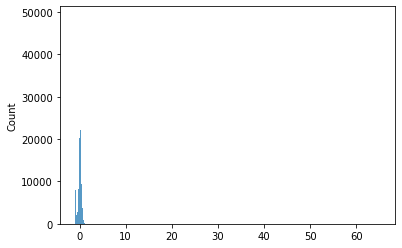

In [62]:
sns.histplot(all_bins_mean)

<AxesSubplot:ylabel='Count'>

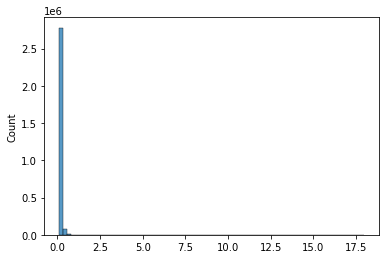

In [69]:
sns.histplot(all_bins_std, bins=80)

In [71]:
all_bins_std.median()

0.20387476682662964

In [105]:
all_bins_mean.max()

65.08242797851562

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

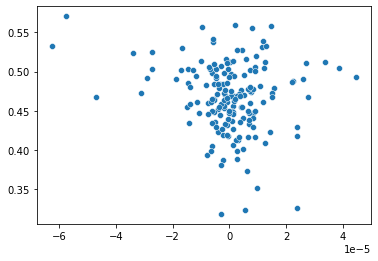

In [59]:
sns.scatterplot(all_bins_mean, all_bins_std)

In [139]:
import random
bin_random = random.sample(range(2875011), 10)

In [166]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 5]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean > 0.5].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean > 12].index.tolist()]

#features = df_gene_tp_all_info_mean.loc[:, bin_random]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

In [167]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

In [214]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)


In [221]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Spectral", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)


In [170]:
all_bins_mean.median()

0.06591205298900604

In [207]:
df_gene_tp_all_info_mean = df_gene_tp_all_info_mean.sample(frac = 1)

In [179]:
df_gene_tp_all_info_mean

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -0.882395 -0.882395 -0.882395 -0.882395   
                        Chandelier_2 -0.785714 -0.785714 -0.785714 -0.785714   
             Lamp5      Lamp5_1      -0.927184 -0.927184 -0.927184 -0.927184   
                        Lamp5_2      -0.885508 -0.885508 -0.885508 -0.885508   
                        Lamp5_3      -0.898069 -0.898069 -0.898069 -0.898069   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.402464 -0.402464 -0.402464 -0.402464   
                        Oligo_8      -0.772555 -0.772555 -0.772555 -0.772555   
                        Oligo_9      -0.977664 -0.977664 -0.977664 -0.977664   
             VLMC       VLMC_1       -0.880988 -0.880988 -0.880988 -0.880988   
                        VLMC_2       -0.702171 -0.702171 -0.702171 -0.702171   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -0.882395 -0.882395 -0.882395 -0.882395   
                        Chandelier_2 -0.785714 -0.785714 -0.785714 -0.785714   
             Lamp5      Lamp5_1      -0.927184 -0.927184 -0.927184 -0.927184   
                        Lamp5_2      -0.885508 -0.885508 -0.885508 -0.885508   
                        Lamp5_3      -0.898069 -0.898069 -0.898069 -0.898069   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.402464 -0.402464 -0.402464 -0.402464   
                        Oligo_8      -0.772555 -0.772555 -0.772555 -0.772555   
                        Oligo_9      -0.977664 -0.977664 -0.977664 -0.977664   
             VLMC       VLMC_1       -0.880988 -0.880988 -0.880988 -0.880988   
                        VLMC_2       -0.702171 -0.702171 -0.702171 -0.702171   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -0.882395 -0.882395  ... -1.206051   
                        Chandelier_2 -0.785714 -0.785714  ... -0.919366   
             Lamp5      Lamp5_1      -0.927184 -0.927184  ... -1.018394   
                        Lamp5_2      -0.885508 -0.885508  ... -1.044661   
                        Lamp5_3      -0.898069 -0.898069  ... -1.052276   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.402464 -0.402464  ... -0.491964   
                        Oligo_8      -0.772555 -0.772555  ... -0.875512   
                        Oligo_9      -0.977664 -0.977664  ... -1.001657   
             VLMC       VLMC_1       -0.880988 -0.880988  ... -0.994492   
                        VLMC_2       -0.702171 -0.702171  ... -0.816006   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.206051 -1.206051 -1.206051 -1.206051   
                        Chandelier_2 -0.919366 -0.919366 -0.919366 -0.919366   
             Lamp5      Lamp5_1      -1.018394 -1.018394 -1.018394 -1.018394   
                        Lamp5_2      -1.044661 -1.044661 -1.044661 -1.044661   
                        Lamp5_3      -1.052276 -1.052276 -1.052276 -1.052276   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.491964 -0.491964 -0.491964 -0.491964   
                        Oligo_8      -0.875512 -0.875512 -0.875512 -0.875512   
                        Oligo_9      -1.001657 -1.001657 -1.001657 -1.001657   
             VLMC       VLMC_1       -0.994492 -0.994492 -0.994492 -0.994492   
                     

In [195]:
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean > 0.1].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff1f03a5dc0> (for post_execute):


KeyboardInterrupt: 

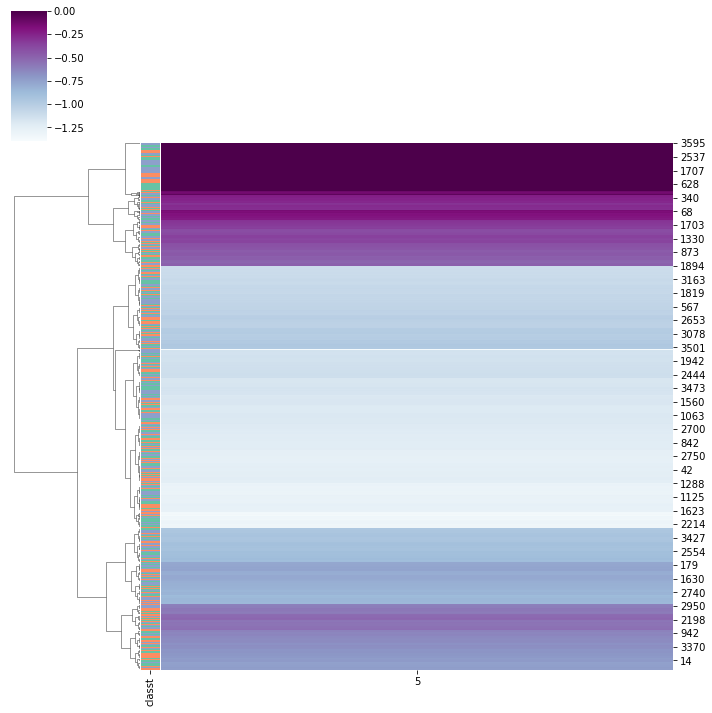

In [188]:
sns.clustermap(df_gene_tp.loc[:, [5]].reset_index(drop=True), cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


In [202]:
row_colors

Index(['#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c',
       '#e41a1c', '#e41a1c', '#e41a1c', '#e41a1c',
       ...
       '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a',
       '#4daf4a', '#4daf4a', '#4daf4a', '#4daf4a'],
      dtype='object', name='classt', length=170)

In [219]:
row_colors2

Index(['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f',
       '#8da0cb', '#e5c494', '#b3b3b3', '#66c2a5',
       ...
       '#66c2a5', '#8da0cb', '#66c2a5', '#8da0cb', '#fc8d62', '#ffd92f',
       '#e5c494', '#e5c494', '#ffd92f', '#66c2a5'],
      dtype='object', name='group', length=170)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



KeyboardInterrupt: 

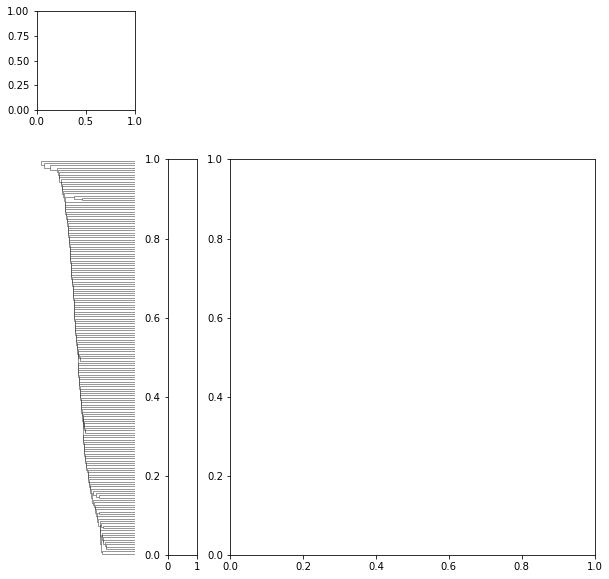

In [228]:
sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", row_colors=[row_colors2, row_colors], vmax=2)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



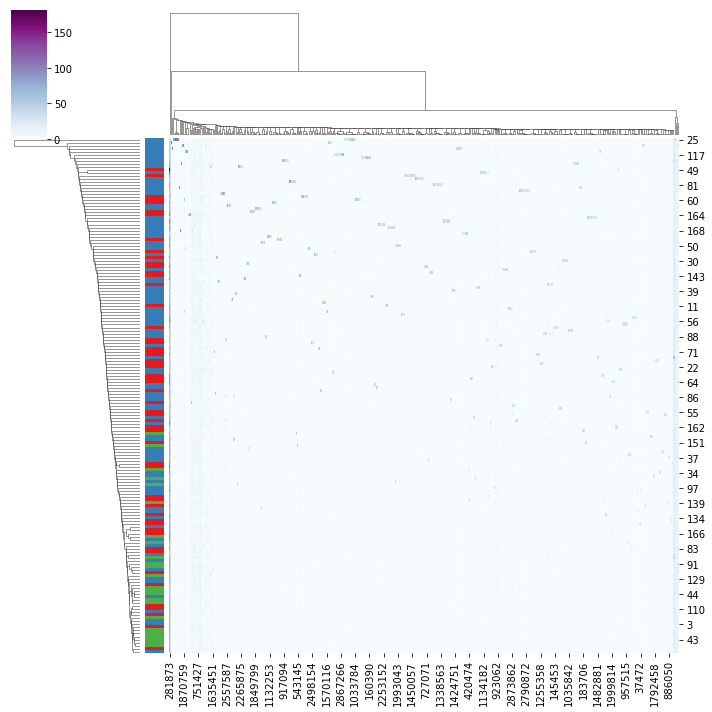

In [236]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 2].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors)


In [229]:
all_bins_std.max()

17.956958770751953

In [144]:
df_gene_tp.loc[:, bin_random].reset_index(drop=True)

2555762   679858    726613    1666589   2762339   2765508   1785609  \
0     0.454061 -1.002658 -1.002658  0.454061  0.454061  0.454061 -1.002658   
1    -0.359442 -0.359442 -0.359442  2.290267 -0.359442 -0.359442 -0.359442   
2     1.465658  0.132706  0.132706  0.132706  1.465658  0.132706  0.132706   
3     0.061154  0.000000  0.061154 -1.186174  0.061154  0.061154  0.061154   
4     1.424739 -1.174784 -1.174784  0.000000  0.124978  0.124978  0.124978   
...        ...       ...       ...       ...       ...       ...       ...   
3595  0.782952  0.782952 -0.815300 -0.815300  0.782952  0.782952 -0.815300   
3596 -0.060594 -0.060594 -0.060594 -0.060594 -0.060594 -0.060594 -0.060594   
3597 -0.448294 -0.448294  1.833936  1.833936 -0.448294 -0.448294 -0.448294   
3598 -0.572756 -0.572756 -0.572756  1.212348 -0.572756 -0.572756 -0.572756   
3599 -0.358167  2.373816 -0.358167 -0.358167 -0.358167 -0.358167 -0.358167   

       1320335   2164707   2654422  
0     0.454061  0.454061 -1.002658  
1    -0.359442 -0.359442 -0.359442  
2     0.132706 -1.200246 -1.200246  
3     1.308483  0.061154 -1.186174  
4     0.124978 -1.174784 -1.174784  
...        ...       ...       ...  
3595 -0.815300  0.782952 -0.815300  
3596 -0.060594  1.170590 -1.291777  
3597 -0.448294  1.833936 -0.448294  
3598 -0.572756 -0.572756 -0.572756  
3599 -0.358167 -0.358167 -0.358167  

[3600 rows x 10 columns]

In [142]:
df_gene_tp_all_info_mean.index.get_level_values('classt')

Index(['GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic',
       'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic', 'GABAergic',
       ...
       'Non-neuronal', 'Non-neuronal', 'Non-neuronal', 'Non-neuronal',
       'Non-neuronal', 'Non-neuronal', 'Non-neuronal', 'Non-neuronal',
       'Non-neuronal', 'Non-neuronal'],
      dtype='object', name='classt', length=170)

In [131]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [9]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

In [11]:
marker_list = marker_list.sample(frac=1)

In [12]:
df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]



In [19]:
df_gene_tp_na = df_gene_tp.fillna(0)

In [14]:
import random
bin_random = random.sample(range(2875011), 1000)

In [21]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [16]:
import seaborn as sns
%matplotlib inline

In [186]:
lut = dict(zip( marker_list.classt.drop_duplicates(), sns.color_palette("Set2", marker_list.classt.drop_duplicates().shape[0]).as_hex()[:]))


row_colors = marker_list.classt.map(lut)

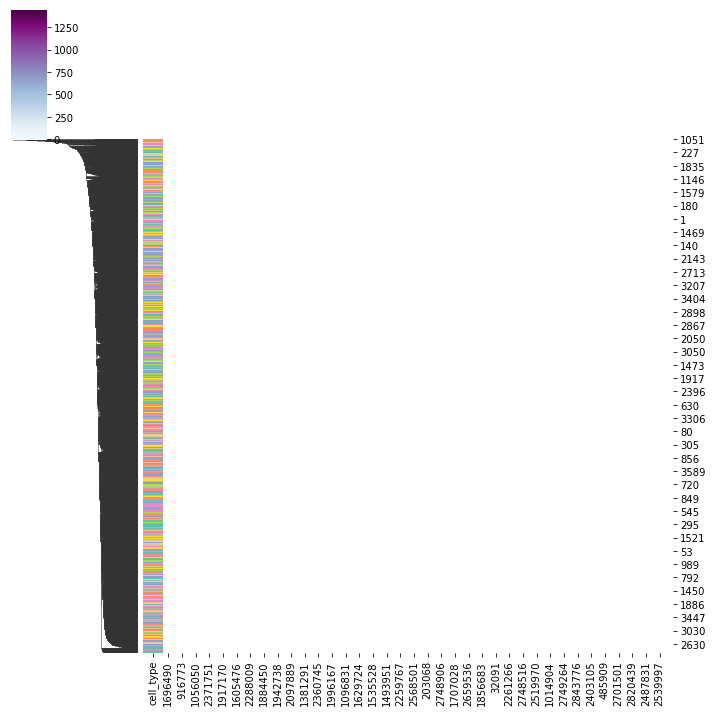

In [24]:
sns.clustermap(df_gene_tp_na.loc[:, given_bins].reset_index(drop=True), cmap="BuPu", row_colors=row_colors.reset_index(drop=True), col_cluster=False, robust=False)


In [ ]:
sns.clustermap(df_gene_tp_na.loc[:, given_bins].reset_index(drop=True), cmap="BuPu", row_colors=row_colors.reset_index(drop=True), col_cluster=False, robust=False)


In [ ]:
df_gene_tp = df_gene_tp.fillna(0)

<AxesSubplot:xlabel='0', ylabel='Count'>

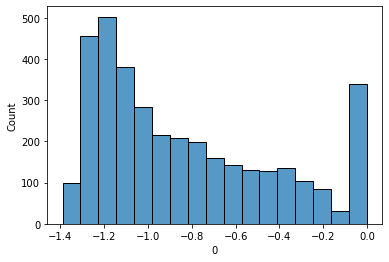

In [45]:
import seaborn as sns
%matplotlib inline
sns.histplot(df_gene_tp[0])

In [61]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    
    

In [ ]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, :]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [54]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [55]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}
)


fig_2d.show()

In [27]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}
)


fig_2d.show()

NameError: name 'px' is not defined

In [41]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [26]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

NameError: name 'px' is not defined